In [3]:
# Cell 1: Imports and Database Connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import psycopg2
import json
import warnings
warnings.filterwarnings('ignore')

# Database connection
def load_data():
    conn = psycopg2.connect(
        host="localhost",
        port=5434,
        database="vv8_backend",
        user="vv8",
        password="vv8"
    )
    
    query = "SELECT * FROM multicore_static_info_known_companies"
    df = pd.read_sql(query, conn)
    conn.close()
    
    print(f"Loaded {len(df)} scripts from database")
    return df

df = load_data()


Loaded 2229 scripts from database


In [4]:
# Cell 2: Analyze Vendor Distribution (Positives Only)
# Filter positive scripts to analyze vendor distribution
positive_df = df[df['label'] == 1].copy()
negative_df = df[df['label'] == 0].copy()

print("Dataset Overview:")
print(f"Total scripts: {len(df)}")
print(f"Positive scripts: {len(positive_df)}")
print(f"Negative scripts: {len(negative_df)}")
print(f"Unique vendors in positives: {positive_df['vendor'].nunique()}")
print(f"Null vendors in negatives: {negative_df['vendor'].isnull().sum()}")

# Vendor distribution analysis (positives only)
vendor_counts = positive_df['vendor'].value_counts()
print(f"\nVendor Distribution (Positive Scripts Only):")
print(vendor_counts)

# Categorize vendors by frequency
high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()

print(f"\nVendor Categories:")
print(f"High volume (>20 scripts): {len(high_volume_vendors)} vendors")
print(f"  - {high_volume_vendors}")
print(f"Medium volume (5-20 scripts): {len(medium_volume_vendors)} vendors") 
print(f"  - {medium_volume_vendors}")
print(f"Low volume (<5 scripts): {len(low_volume_vendors)} vendors")
print(f"  - {low_volume_vendors}")


Dataset Overview:
Total scripts: 2229
Positive scripts: 232
Negative scripts: 244
Unique vendors in positives: 18
Null vendors in negatives: 244

Vendor Distribution (Positive Scripts Only):
vendor
Iovation      81
Forter        53
Human         27
BioCatch      21
Behaviosec     9
Yofi           8
Sardine        6
Nudata         6
PingOne        5
Cheq           4
Accertify      3
Feedzai        2
Transmit       2
Datadome       1
Callsign       1
Threatmark     1
GroupIB        1
Utarget        1
Name: count, dtype: int64

Vendor Categories:
High volume (>20 scripts): 4 vendors
  - ['Iovation', 'Forter', 'Human', 'BioCatch']
Medium volume (5-20 scripts): 5 vendors
  - ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
Low volume (<5 scripts): 9 vendors
  - ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']


In [6]:
# Cell 4: Enhanced Feature Engineering (Based on your original)
def engineer_features(df):
    """
    Engineer features with your original approach, just adapted for database format
    """
    features_list = []
    
    for idx, row in df.iterrows():
        try:
            # Convert row to script-like dictionary format (matching your original method)
            script = row.to_dict()
            
            features = {}
            
            # Core aggregation features (your original approach)
            features['max_api_aggregation_score'] = script.get('max_api_aggregation_score', -1)
            features['behavioral_api_agg_count'] = script.get('behavioral_api_agg_count', -1)
            features['fp_api_agg_count'] = script.get('fp_api_agg_count', -1)
            
            # Volume indicators
            features['behavioral_source_api_count'] = script.get('behavioral_source_api_count', 0)
            features['fingerprinting_source_api_count'] = script.get('fingerprinting_source_api_count', 0)
            
            # Data flow indicators
            features['dataflow_to_sink'] = int(script.get('dataflow_to_sink', False))
            
            # API access intensity - safe JSON parsing
            try:
                behavioral_access = json.loads(script.get('behavioral_apis_access_count', '{}')) if script.get('behavioral_apis_access_count') else {}
            except:
                behavioral_access = {}
                
            try:
                fp_access = json.loads(script.get('fingerprinting_api_access_count', '{}')) if script.get('fingerprinting_api_access_count') else {}
            except:
                fp_access = {}
            
            features['total_behavioral_api_accesses'] = sum(behavioral_access.values())
            features['total_fp_api_accesses'] = sum(fp_access.values())
            features['unique_behavioral_apis'] = len(behavioral_access)
            features['unique_fp_apis'] = len(fp_access)
            
            # Sink analysis
            try:
                sink_data = json.loads(script.get('apis_going_to_sink', '{}')) if script.get('apis_going_to_sink') else {}
            except:
                sink_data = {}
                
            features['num_sink_types'] = len(sink_data)
            features['has_storage_sink'] = int(any('Storage' in str(sink) for sink in sink_data.keys()))
            features['has_network_sink'] = int(any(sink in ['XMLHttpRequest.send', 'Navigator.sendBeacon', 'fetch'] 
                                                  for sink in sink_data.keys()))
            
            # Behavioral event diversity
            try:
                behavioral_sources = json.loads(script.get('behavioral_source_apis', '[]')) if script.get('behavioral_source_apis') else []
            except:
                behavioral_sources = []
                
            features['mouse_event_count'] = sum(1 for api in behavioral_sources if 'MouseEvent' in str(api))
            features['keyboard_event_count'] = sum(1 for api in behavioral_sources if 'KeyboardEvent' in str(api))
            features['touch_event_count'] = sum(1 for api in behavioral_sources if 'TouchEvent' in str(api) or 'Touch.' in str(api))
            features['pointer_event_count'] = sum(1 for api in behavioral_sources if 'PointerEvent' in str(api))
            features['behavioral_event_diversity'] = sum([
                features['mouse_event_count'] > 0,
                features['keyboard_event_count'] > 0,
                features['touch_event_count'] > 0,
                features['pointer_event_count'] > 0
            ])
            
            # Ratio features
            total_apis = features['behavioral_source_api_count'] + features['fingerprinting_source_api_count']
            if total_apis > 0:
                features['behavioral_ratio'] = features['behavioral_source_api_count'] / total_apis
                features['intensity_ratio'] = features['total_behavioral_api_accesses'] / total_apis
            else:
                features['behavioral_ratio'] = 0
                features['intensity_ratio'] = 0
            
            # Store metadata
            features['script_id'] = script.get('script_id')
            features['label'] = script['label']
            features['vendor'] = script.get('vendor') if pd.notna(script.get('vendor')) else 'negative'
            
            features_list.append(features)
            
        except Exception as e:
            print(f"⚠️  Feature extraction error for script {row.get('script_id', 'unknown')}: {e}")
            continue
    
    return pd.DataFrame(features_list)

print("Engineering features...")
features_df = engineer_features(df)
print(f"Created {len([col for col in features_df.columns if col not in ['script_id', 'label', 'vendor']])} features for {len(features_df)} scripts")

Engineering features...
Created 20 features for 2229 scripts


In [7]:
features_df


,max_api_aggregation_score,behavioral_api_agg_count,fp_api_agg_count,behavioral_source_api_count,fingerprinting_source_api_count,dataflow_to_sink,total_behavioral_api_accesses,total_fp_api_accesses,unique_behavioral_apis,unique_fp_apis,...,mouse_event_count,keyboard_event_count,touch_event_count,pointer_event_count,behavioral_event_diversity,behavioral_ratio,intensity_ratio,script_id,label,vendor
0,1.0,1.0,0.0,10.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1.000000,0.0,7392023,-1,negative
1,1.0,1.0,0.0,1.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.0,7392036,-1,negative
2,8.0,8.0,0.0,25.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1.000000,0.0,7392015,-1,negative
3,5.0,3.0,2.0,3.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0.428571,0.0,7392039,-1,negative
4,2.0,2.0,0.0,2.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0.666667,0.0,7392076,-1,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,9.0,9.0,0.0,19.0,17.0,0,0,0,0,0,...,0,0,0,0,0,0.527778,0.0,7403607,1,Iovation
2225,11.0,2.0,9.0,5.0,18.0,1,0,0,0,0,...,0,0,0,0,0,0.217391,0.0,7402719,1,Forter
2226,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,...,0,0,0,0,0,0.630435,0.0,7406891,1,Iovation
2227,18.0,18.0,0.0,24.0,17.0,0,0,0,0,0,...,0,0,0,0,0,0.585366,0.0,7394204,1,Iovation


In [8]:
# Cell 5: Vendor-Aware Split (Positives Only)
def create_vendor_aware_split(features_df, test_size=0.3, random_state=42):
    """
    Create train/test split where:
    - Negatives are split randomly
    - Positives are split with vendor awareness to prevent leakage
    """
    np.random.seed(random_state)
    
    # Separate positives and negatives
    positives = features_df[features_df['label'] == 1].copy()
    negatives = features_df[features_df['label'] == 0].copy()
    
    print(f"Splitting {len(positives)} positives and {len(negatives)} negatives...")
    
    # Analyze positive vendor distribution
    vendor_counts = positives['vendor'].value_counts()
    high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
    medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
    low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()
    
    train_pos_indices = []
    test_pos_indices = []
    
    # High volume vendors: Split scripts within vendor (70-30)
    for vendor in high_volume_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        np.random.shuffle(vendor_scripts)
        
        n_test = max(1, int(len(vendor_scripts) * test_size))
        test_pos_indices.extend(vendor_scripts[:n_test])
        train_pos_indices.extend(vendor_scripts[n_test:])
        
        print(f"High volume vendor '{vendor}': {len(vendor_scripts)} scripts -> {len(vendor_scripts)-n_test} train, {n_test} test")
    
    # Medium volume vendors: 60% vendors to train, 40% vendors to test
    np.random.shuffle(medium_volume_vendors)
    n_train_vendors = max(1, int(len(medium_volume_vendors) * 0.6))
    
    train_medium_vendors = medium_volume_vendors[:n_train_vendors]
    test_medium_vendors = medium_volume_vendors[n_train_vendors:]
    
    for vendor in train_medium_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        train_pos_indices.extend(vendor_scripts)
        print(f"Medium volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to train")
    
    for vendor in test_medium_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        test_pos_indices.extend(vendor_scripts)
        print(f"Medium volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to test")
    
    # Low volume vendors: 50% to train, 50% to test (by vendor)
    np.random.shuffle(low_volume_vendors)
    n_test_low_vendors = len(low_volume_vendors) // 2
    
    train_low_vendors = low_volume_vendors[n_test_low_vendors:]
    test_low_vendors = low_volume_vendors[:n_test_low_vendors]
    
    for vendor in train_low_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        train_pos_indices.extend(vendor_scripts)
        print(f"Low volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to train")
    
    for vendor in test_low_vendors:
        vendor_scripts = positives[positives['vendor'] == vendor].index.tolist()
        test_pos_indices.extend(vendor_scripts)
        print(f"Low volume vendor '{vendor}': {len(vendor_scripts)} scripts -> all to test")
    
    # Split negatives randomly
    neg_indices = negatives.index.tolist()
    np.random.shuffle(neg_indices)
    n_test_neg = int(len(neg_indices) * test_size)
    
    train_neg_indices = neg_indices[n_test_neg:]
    test_neg_indices = neg_indices[:n_test_neg]
    
    # Combine indices
    train_indices = train_pos_indices + train_neg_indices
    test_indices = test_pos_indices + test_neg_indices
    
    print(f"\nFinal split:")
    print(f"Train: {len(train_pos_indices)} positives + {len(train_neg_indices)} negatives = {len(train_indices)} total")
    print(f"Test: {len(test_pos_indices)} positives + {len(test_neg_indices)} negatives = {len(test_indices)} total")
    
    return train_indices, test_indices, {
        'train_vendors': {
            'high_volume_partial': high_volume_vendors,
            'medium_volume': train_medium_vendors,
            'low_volume': train_low_vendors
        },
        'test_vendors': {
            'high_volume_partial': high_volume_vendors,  # Same vendors, different scripts
            'medium_volume': test_medium_vendors,
            'low_volume': test_low_vendors
        }
    }

train_idx, test_idx, split_info = create_vendor_aware_split(features_df)

# Create train/test sets
feature_cols = [col for col in features_df.columns if col not in ['script_id', 'label', 'vendor']]
X_train = features_df.loc[train_idx, feature_cols]
y_train = features_df.loc[train_idx, 'label']
X_test = features_df.loc[test_idx, feature_cols]
y_test = features_df.loc[test_idx, 'label']

print(f"\nTraining set labels: {y_train.value_counts().to_dict()}")
print(f"Test set labels: {y_test.value_counts().to_dict()}")


Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low volume vendor 'Threatmark': 1 scripts -> all to train
Low volume vendor 'GroupIB': 1 scripts -> all to train
Low volume vendor 'Utarget': 1 scripts -> all to test
Low volume vendor 'Accertify': 3 scripts -> all to test
Low volume vendor 'Datadome': 1 scrip

In [11]:
X_train.head()

,max_api_aggregation_score,behavioral_api_agg_count,fp_api_agg_count,behavioral_source_api_count,fingerprinting_source_api_count,dataflow_to_sink,total_behavioral_api_accesses,total_fp_api_accesses,unique_behavioral_apis,unique_fp_apis,num_sink_types,has_storage_sink,has_network_sink,mouse_event_count,keyboard_event_count,touch_event_count,pointer_event_count,behavioral_event_diversity,behavioral_ratio,intensity_ratio
2121,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630435,0.0
2191,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630435,0.0
2153,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630435,0.0
2178,15.0,15.0,0.0,18.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000,0.0
1381,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630435,0.0


In [12]:
# Cell 6: Create Vendor Weights and Train Model
def create_vendor_weights(features_df, train_idx):
    """Create inverse frequency weights for positive vendors only"""
    train_df = features_df.loc[train_idx]
    train_positives = train_df[train_df['label'] == 1]
    
    if len(train_positives) == 0:
        return np.ones(len(train_idx))
    
    vendor_counts = train_positives['vendor'].value_counts()
    
    # Inverse square root for gentler weighting
    vendor_weights = 1 / np.sqrt(vendor_counts)
    vendor_weights = vendor_weights / vendor_weights.sum() * len(vendor_weights)
    
    print("Vendor weights for positive scripts:")
    for vendor, weight in vendor_weights.items():
        count = vendor_counts[vendor]
        print(f"  {vendor}: {weight:.3f} (count: {count})")
    
    # Create sample weights
    sample_weights = np.ones(len(train_idx))
    
    for i, idx in enumerate(train_idx):
        row = features_df.loc[idx]
        if row['label'] == 1:  # Only weight positive samples
            vendor = row['vendor']
            if vendor in vendor_weights:
                sample_weights[i] = vendor_weights[vendor]
    
    return sample_weights

# Get sample weights
sample_weights = create_vendor_weights(features_df, train_idx)

# Train model
print(f"\nTraining RandomForest with {len(feature_cols)} features...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf.fit(X_train, y_train, sample_weight=sample_weights)


Vendor weights for positive scripts:
  Iovation: 0.256 (count: 57)
  Forter: 0.314 (count: 38)
  Human: 0.444 (count: 19)
  BioCatch: 0.500 (count: 15)
  Yofi: 0.684 (count: 8)
  Nudata: 0.790 (count: 6)
  PingOne: 0.866 (count: 5)
  Cheq: 0.968 (count: 4)
  Feedzai: 1.369 (count: 2)
  Callsign: 1.936 (count: 1)
  Threatmark: 1.936 (count: 1)
  GroupIB: 1.936 (count: 1)

Training RandomForest with 20 features...


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

=== OVERALL PERFORMANCE ===
Accuracy: 0.912
ROC AUC: 0.976

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        73
           1       0.94      0.88      0.91        75

    accuracy                           0.91       148
   macro avg       0.91      0.91      0.91       148
weighted avg       0.91      0.91      0.91       148



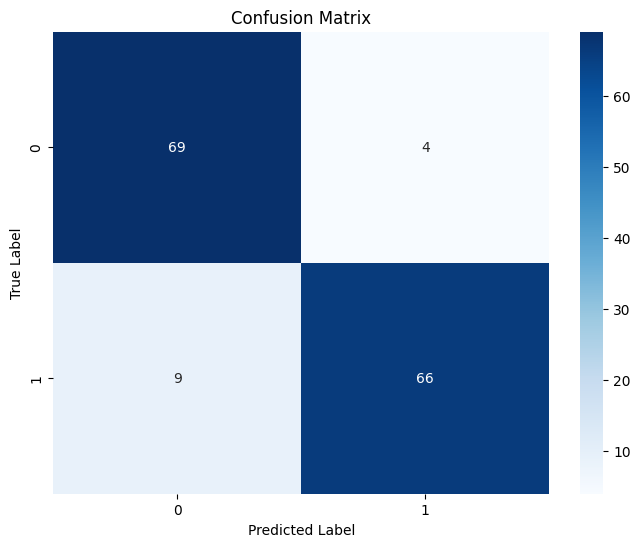

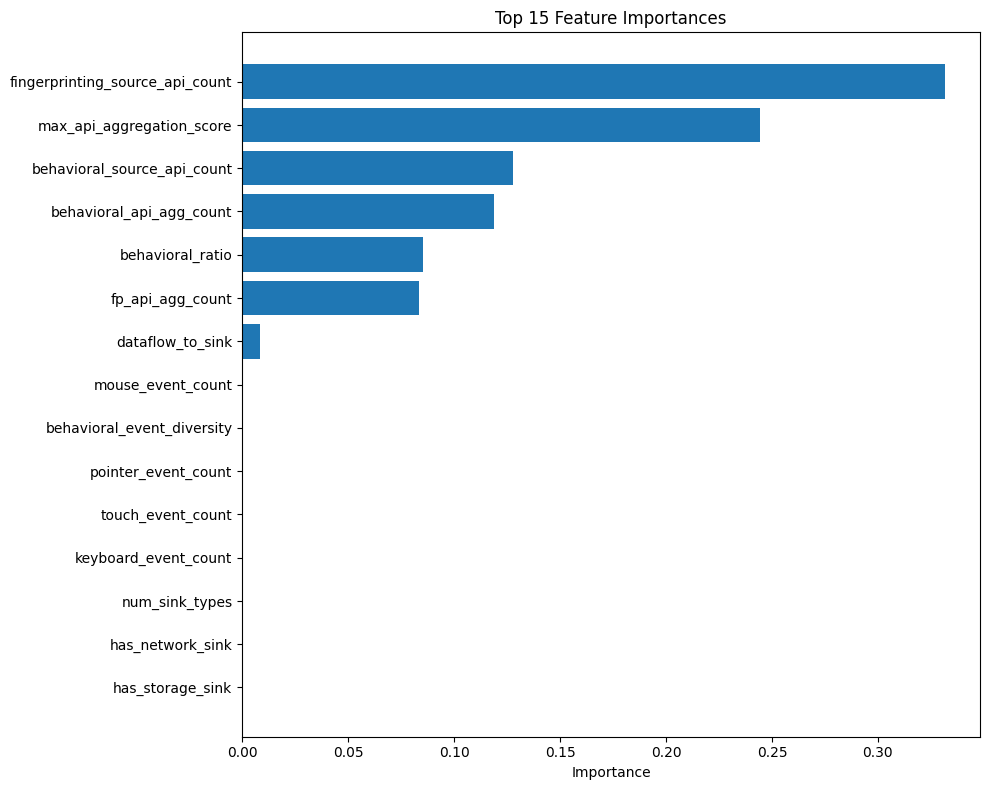


Top 10 Most Important Features:
                            feature  importance
4   fingerprinting_source_api_count    0.331608
0         max_api_aggregation_score    0.244275
3       behavioral_source_api_count    0.127587
1          behavioral_api_agg_count    0.118980
18                 behavioral_ratio    0.085337
2                  fp_api_agg_count    0.083627
5                  dataflow_to_sink    0.008586
13                mouse_event_count    0.000000
17       behavioral_event_diversity    0.000000
16              pointer_event_count    0.000000


In [13]:
# Cell 7: Model Evaluation and Analysis
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Overall performance
print("=== OVERALL PERFORMANCE ===")
print(f"Accuracy: {rf.score(X_test, y_test):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))



=== VENDOR-SPECIFIC PERFORMANCE (Positives Only) ===
       vendor  accuracy  count category
0    Iovation       1.0     24     high
1      Forter       1.0     15     high
2       Human       1.0      8     high
3    BioCatch       1.0      6     high
5  Behaviosec       1.0      9   medium
6     Utarget       1.0      1      low
8    Datadome       1.0      1      low
9    Transmit       1.0      2      low
4     Sardine       0.0      6   medium
7   Accertify       0.0      3      low


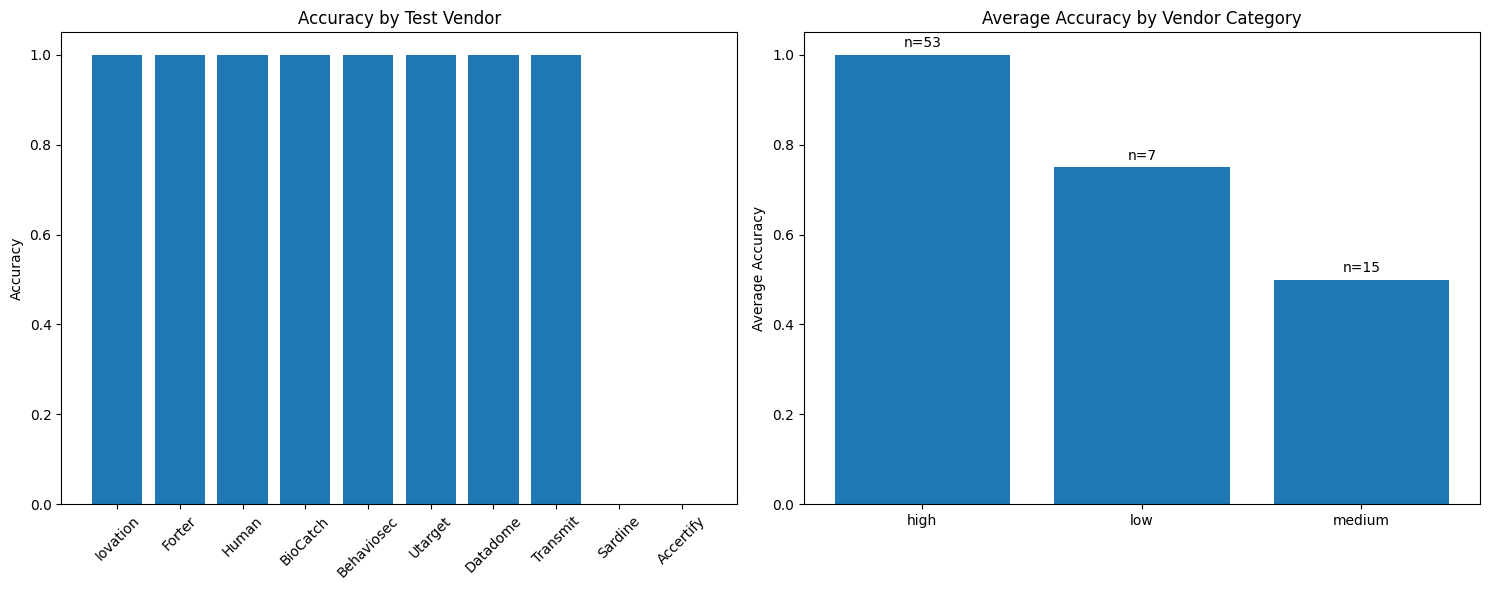


Category Performance Summary:
  category  accuracy  count
0     high      1.00     53
1      low      0.75      7
2   medium      0.50     15

=== GENERALIZATION ANALYSIS ===
Seen vendor types (partial scripts): 4 vendors
Unseen vendor types (medium): 2 vendors
Unseen vendor types (low): 4 vendors


In [14]:
# Cell 8: Vendor-Specific Analysis
# Analyze performance by vendor category
test_df = features_df.loc[test_idx].copy()
test_df['predictions'] = y_pred
test_df['pred_proba'] = y_pred_proba

# Performance on positives by vendor
test_positives = test_df[test_df['label'] == 1]
if len(test_positives) > 0:
    print("\n=== VENDOR-SPECIFIC PERFORMANCE (Positives Only) ===")
    
    vendor_performance = []
    for vendor in test_positives['vendor'].unique():
        vendor_data = test_positives[test_positives['vendor'] == vendor]
        accuracy = (vendor_data['predictions'] == vendor_data['label']).mean()
        count = len(vendor_data)
        
        vendor_performance.append({
            'vendor': vendor,
            'accuracy': accuracy,
            'count': count,
            'category': 'high' if vendor in split_info['train_vendors']['high_volume_partial']
                      else 'medium' if vendor in split_info['test_vendors']['medium_volume']
                      else 'low'
        })
    
    vendor_perf_df = pd.DataFrame(vendor_performance).sort_values('accuracy', ascending=False)
    print(vendor_perf_df)
    
    # Visualization of vendor performance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Performance by vendor
    axes[0].bar(range(len(vendor_perf_df)), vendor_perf_df['accuracy'])
    axes[0].set_title('Accuracy by Test Vendor')
    axes[0].set_xticks(range(len(vendor_perf_df)))
    axes[0].set_xticklabels(vendor_perf_df['vendor'], rotation=45)
    axes[0].set_ylabel('Accuracy')
    
    # Performance by category
    category_perf = vendor_perf_df.groupby('category').agg({
        'accuracy': 'mean',
        'count': 'sum'
    }).reset_index()
    
    bars = axes[1].bar(category_perf['category'], category_perf['accuracy'])
    axes[1].set_title('Average Accuracy by Vendor Category')
    axes[1].set_ylabel('Average Accuracy')
    
    # Add count labels on bars
    for bar, count in zip(bars, category_perf['count']):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'n={count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCategory Performance Summary:")
    print(category_perf)

print("\n=== GENERALIZATION ANALYSIS ===")
print(f"Seen vendor types (partial scripts): {len(split_info['train_vendors']['high_volume_partial'])} vendors")
print(f"Unseen vendor types (medium): {len(split_info['test_vendors']['medium_volume'])} vendors") 
print(f"Unseen vendor types (low): {len(split_info['test_vendors']['low_volume'])} vendors")


In [15]:
test_df.head()

,max_api_aggregation_score,behavioral_api_agg_count,fp_api_agg_count,behavioral_source_api_count,fingerprinting_source_api_count,dataflow_to_sink,total_behavioral_api_accesses,total_fp_api_accesses,unique_behavioral_apis,unique_fp_apis,...,touch_event_count,pointer_event_count,behavioral_event_diversity,behavioral_ratio,intensity_ratio,script_id,label,vendor,predictions,pred_proba
2097,18.0,18.0,0.0,32.0,17.0,0,0,0,0,0,...,0,0,0,0.653061,0.0,7393373,1,Iovation,1,0.995344
63,18.0,18.0,0.0,32.0,17.0,0,0,0,0,0,...,0,0,0,0.653061,0.0,7392626,1,Iovation,1,0.995344
2054,12.0,12.0,0.0,14.0,17.0,0,0,0,0,0,...,0,0,0,0.451613,0.0,7399754,1,Iovation,1,0.787537
2099,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,...,0,0,0,0.630435,0.0,7408293,1,Iovation,1,1.000000
1934,15.0,15.0,0.0,26.0,12.0,0,0,0,0,0,...,0,0,0,0.684211,0.0,7394435,1,Iovation,1,0.975293


## Feature Engineering (Vendor agnostic)


In [16]:
# Cell 1: Enhanced Feature Engineering with Vendor-Agnostic Features
def engineer_enhanced_features(df):
    """
    Enhanced feature engineering focusing on vendor-agnostic patterns
    """
    features_list = []
    
    for idx, row in df.iterrows():
        try:
            script = row.to_dict()
            features = {}
            
            # Parse JSON data safely
            try:
                behavioral_access = json.loads(script.get('behavioral_apis_access_count', '{}')) if script.get('behavioral_apis_access_count') else {}
            except:
                behavioral_access = {}
                
            try:
                fp_access = json.loads(script.get('fingerprinting_api_access_count', '{}')) if script.get('fingerprinting_api_access_count') else {}
            except:
                fp_access = {}
            
            try:
                behavioral_sources = json.loads(script.get('behavioral_source_apis', '[]')) if script.get('behavioral_source_apis') else []
            except:
                behavioral_sources = []
                
            try:
                fp_sources = json.loads(script.get('fingerprinting_source_apis', '[]')) if script.get('fingerprinting_source_apis') else []
            except:
                fp_sources = []
                
            try:
                sink_data = json.loads(script.get('apis_going_to_sink', '{}')) if script.get('apis_going_to_sink') else {}
            except:
                sink_data = {}
            
            # === ORIGINAL FEATURES ===
            features['max_api_aggregation_score'] = script.get('max_api_aggregation_score', -1)
            features['behavioral_api_agg_count'] = script.get('behavioral_api_agg_count', -1)
            features['fp_api_agg_count'] = script.get('fp_api_agg_count', -1)
            features['behavioral_source_api_count'] = script.get('behavioral_source_api_count', 0)
            features['fingerprinting_source_api_count'] = script.get('fingerprinting_source_api_count', 0)
            features['dataflow_to_sink'] = int(script.get('dataflow_to_sink', False))
            
            # === ENHANCED VENDOR-AGNOSTIC FEATURES ===
            
            # 1. API DIVERSITY AND DISTRIBUTION PATTERNS
            total_behavioral_accesses = sum(behavioral_access.values())
            total_fp_accesses = sum(fp_access.values())
            unique_behavioral_apis = len(behavioral_access)
            unique_fp_apis = len(fp_access)
            
            # Access distribution patterns
            if behavioral_access:
                access_values = list(behavioral_access.values())
                features['behavioral_access_entropy'] = -sum((v/total_behavioral_accesses) * np.log2(v/total_behavioral_accesses) 
                                                           for v in access_values if v > 0)
                features['behavioral_access_gini'] = 1 - sum((v/total_behavioral_accesses)**2 for v in access_values)
                features['behavioral_access_std'] = np.std(access_values)
                features['behavioral_access_cv'] = np.std(access_values) / (np.mean(access_values) + 1e-8)
                features['max_behavioral_access_ratio'] = max(access_values) / (total_behavioral_accesses + 1e-8)
            else:
                features['behavioral_access_entropy'] = 0
                features['behavioral_access_gini'] = 0
                features['behavioral_access_std'] = 0
                features['behavioral_access_cv'] = 0
                features['max_behavioral_access_ratio'] = 0
            
            # 2. EVENT TYPE SOPHISTICATION
            event_categories = {
                'user_interaction': ['MouseEvent', 'KeyboardEvent', 'PointerEvent', 'TouchEvent', 'Touch.'],
                'focus_navigation': ['FocusEvent'],
                'device_motion': ['DeviceMotion', 'DeviceOrientation'],
                'timing_events': ['timeStamp', 'interval'],
                'advanced_pointer': ['pressure', 'tiltX', 'tiltY', 'twist', 'tangentialPressure'],
                'touch_advanced': ['force', 'radiusX', 'radiusY'],
                'coordination': ['screenX', 'screenY', 'clientX', 'clientY', 'pageX', 'pageY']
            }
            
            for category, patterns in event_categories.items():
                count = sum(1 for api in behavioral_sources if any(pattern in str(api) for pattern in patterns))
                features[f'{category}_count'] = count
                features[f'{category}_ratio'] = count / max(len(behavioral_sources), 1)
            
            # Event sophistication score
            features['event_sophistication'] = sum([
                features['user_interaction_count'] > 0,
                features['device_motion_count'] > 0,
                features['advanced_pointer_count'] > 0,
                features['touch_advanced_count'] > 0,
                features['coordination_count'] > 5
            ])
            
            # 3. FINGERPRINTING SOPHISTICATION
            fp_categories = {
                'basic_navigator': ['Navigator.userAgent', 'Navigator.platform', 'Navigator.language'],
                'hardware_info': ['Navigator.hardwareConcurrency', 'Navigator.deviceMemory', 'Navigator.maxTouchPoints'],
                'screen_info': ['Screen.width', 'Screen.height', 'Screen.colorDepth', 'Screen.pixelDepth'],
                'advanced_canvas': ['HTMLCanvasElement.toDataURL', 'WebGLRenderingContext.getParameter'],
                'audio_fp': ['AudioBuffer.getChannelData', 'OfflineAudioContext'],
                'timing_fp': ['performance.now', 'Date.getTime'],
                'battery_sensors': ['BatteryManager', 'DeviceMotion', 'DeviceOrientation'],
                'media_devices': ['MediaDevices.enumerateDevices']
            }
            
            for category, patterns in fp_categories.items():
                count = sum(1 for api in fp_sources if any(pattern in str(api) for pattern in patterns))
                features[f'fp_{category}_count'] = count
            
            # Fingerprinting sophistication
            features['fp_sophistication'] = sum([
                features['fp_advanced_canvas_count'] > 0,
                features['fp_audio_fp_count'] > 0,
                features['fp_battery_sensors_count'] > 0,
                features['fp_media_devices_count'] > 0,
                features['fp_hardware_info_count'] > 2
            ])
            
            # 4. API INTERACTION PATTERNS
            total_apis = len(behavioral_sources) + len(fp_sources)
            
            # Complexity ratios
            features['api_diversity_ratio'] = (unique_behavioral_apis + unique_fp_apis) / max(total_apis, 1)
            features['behavioral_dominance'] = unique_behavioral_apis / max(unique_behavioral_apis + unique_fp_apis, 1)
            features['access_concentration'] = (total_behavioral_accesses + total_fp_accesses) / max(total_apis, 1)
            
            # Access efficiency (how much each API is used)
            features['behavioral_efficiency'] = total_behavioral_accesses / max(unique_behavioral_apis, 1)
            features['fp_efficiency'] = total_fp_accesses / max(unique_fp_apis, 1)
            
            # 5. SINK ANALYSIS ENHANCEMENT
            sink_categories = {
                'storage': ['localStorage', 'sessionStorage', 'IndexedDB'],
                'network': ['XMLHttpRequest', 'fetch', 'sendBeacon'],
                'dom_manipulation': ['innerHTML', 'appendChild', 'setAttribute'],
                'script_injection': ['HTMLScriptElement.src', 'eval', 'Function'],
                'form_interaction': ['HTMLInputElement.value', 'HTMLFormElement.submit']
            }
            
            for category, patterns in sink_categories.items():
                has_sink = any(any(pattern in str(sink) for pattern in patterns) for sink in sink_data.keys())
                features[f'has_{category}_sink'] = int(has_sink)
            
            # Sink diversity
            features['sink_diversity'] = sum([
                features['has_storage_sink'],
                features['has_network_sink'],
                features['has_dom_manipulation_sink'],
                features['has_script_injection_sink'],
                features['has_form_interaction_sink']
            ])
            
            # 6. AGGREGATION PATTERN ANALYSIS
            if script.get('max_behavioral_api_aggregation_score', -1) > 0 and script.get('max_fingerprinting_api_aggregation_score', -1) > 0:
                features['aggregation_balance'] = script.get('max_behavioral_api_aggregation_score', 0) / (
                    script.get('max_behavioral_api_aggregation_score', 0) + script.get('max_fingerprinting_api_aggregation_score', 0) + 1e-8
                )
            else:
                features['aggregation_balance'] = 0.5
            
            # Aggregation efficiency
            features['aggregation_efficiency'] = script.get('max_api_aggregation_score', 0) / max(total_apis, 1)
            
            # 7. BEHAVIORAL TIMING AND COORDINATION
            timing_apis = sum(1 for api in behavioral_sources if any(pattern in str(api) 
                            for pattern in ['timeStamp', 'interval', 'Time']))
            coordinate_apis = sum(1 for api in behavioral_sources if any(pattern in str(api) 
                                for pattern in ['clientX', 'clientY', 'screenX', 'screenY', 'pageX', 'pageY']))
            
            features['timing_api_ratio'] = timing_apis / max(len(behavioral_sources), 1)
            features['coordinate_api_ratio'] = coordinate_apis / max(len(behavioral_sources), 1)
            features['precision_tracking'] = int(timing_apis > 0 and coordinate_apis > 0)
            
            # 8. SCRIPT BEHAVIOR CLASSIFICATION
            # Classify the script's primary behavior type
            is_heavy_behavioral = total_behavioral_accesses > 50
            is_heavy_fp = total_fp_accesses > 20
            has_sinks = len(sink_data) > 0
            
            features['behavior_class'] = 0  # Default: minimal
            if is_heavy_behavioral and is_heavy_fp and has_sinks:
                features['behavior_class'] = 3  # Comprehensive tracking
            elif is_heavy_behavioral and has_sinks:
                features['behavior_class'] = 2  # Behavioral focused
            elif is_heavy_fp:
                features['behavior_class'] = 1  # Fingerprinting focused
            
            # Store metadata
            features['script_id'] = script.get('script_id')
            features['label'] = script['label']
            features['vendor'] = script.get('vendor') if pd.notna(script.get('vendor')) else 'negative'
            
            features_list.append(features)
            
        except Exception as e:
            print(f"⚠️  Feature extraction error for script {row.get('script_id', 'unknown')}: {e}")
            continue
    
    return pd.DataFrame(features_list)

print("Engineering enhanced features...")
enhanced_features_df = engineer_enhanced_features(df)
feature_cols = [col for col in enhanced_features_df.columns if col not in ['script_id', 'label', 'vendor']]
print(f"Created {len(feature_cols)} features for {len(enhanced_features_df)} scripts")
print(f"New features added: {len(feature_cols) - len([col for col in features_df.columns if col not in ['script_id', 'label', 'vendor']])}")



Engineering enhanced features...
Created 52 features for 2229 scripts
New features added: 32


In [17]:
enhanced_features_df

,max_api_aggregation_score,behavioral_api_agg_count,fp_api_agg_count,behavioral_source_api_count,fingerprinting_source_api_count,dataflow_to_sink,behavioral_access_entropy,behavioral_access_gini,behavioral_access_std,behavioral_access_cv,...,sink_diversity,aggregation_balance,aggregation_efficiency,timing_api_ratio,coordinate_api_ratio,precision_tracking,behavior_class,script_id,label,vendor
0,1.0,1.0,0.0,10.0,0.0,0,0,0,0,0,...,0,0.500000,1.0,0.0,0.0,0,0,7392023,-1,negative
1,1.0,1.0,0.0,1.0,2.0,0,0,0,0,0,...,0,0.500000,1.0,0.0,0.0,0,0,7392036,-1,negative
2,8.0,8.0,0.0,25.0,0.0,0,0,0,0,0,...,0,0.500000,8.0,0.0,0.0,0,0,7392015,-1,negative
3,5.0,3.0,2.0,3.0,4.0,0,0,0,0,0,...,0,0.428571,5.0,0.0,0.0,0,0,7392039,-1,negative
4,2.0,2.0,0.0,2.0,1.0,0,0,0,0,0,...,0,0.666667,2.0,0.0,0.0,0,0,7392076,-1,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,9.0,9.0,0.0,19.0,17.0,0,0,0,0,0,...,0,0.692308,9.0,0.0,0.0,0,0,7403607,1,Iovation
2225,11.0,2.0,9.0,5.0,18.0,1,0,0,0,0,...,0,0.181818,11.0,0.0,0.0,0,0,7402719,1,Forter
2226,15.0,15.0,0.0,29.0,17.0,0,0,0,0,0,...,0,0.789474,15.0,0.0,0.0,0,0,7406891,1,Iovation
2227,18.0,18.0,0.0,24.0,17.0,0,0,0,0,0,...,0,0.818182,18.0,0.0,0.0,0,0,7394204,1,Iovation


### Feature Vendor Correlation

In [18]:
# Cell 2: Feature-Vendor Correlation Analysis
def analyze_feature_vendor_correlation(features_df):
    """
    Analyze which features correlate strongly with specific vendors
    """
    # Only analyze positive samples (with vendor info)
    positive_features = features_df[features_df['label'] == 1].copy()
    
    # Get numeric features only
    feature_cols = [col for col in positive_features.columns if col not in ['script_id', 'label', 'vendor']]
    numeric_features = positive_features[feature_cols].select_dtypes(include=[np.number])
    
    # One-hot encode vendors
    vendor_dummies = pd.get_dummies(positive_features['vendor'], prefix='vendor')
    
    # Calculate correlations between features and vendors
    correlations = {}
    for vendor_col in vendor_dummies.columns:
        corr_data = []
        for feature in numeric_features.columns:
            corr = numeric_features[feature].corr(vendor_dummies[vendor_col])
            if not np.isnan(corr):
                corr_data.append({
                    'feature': feature,
                    'correlation': abs(corr),
                    'raw_correlation': corr
                })
        
        vendor_name = vendor_col.replace('vendor_', '')
        correlations[vendor_name] = pd.DataFrame(corr_data).sort_values('correlation', ascending=False)
    
    return correlations, numeric_features, vendor_dummies

# Run correlation analysis
print("Analyzing feature-vendor correlations...")
vendor_correlations, numeric_features_pos, vendor_dummies = analyze_feature_vendor_correlation(enhanced_features_df)

# Display top correlated features for each major vendor
print("\n=== TOP VENDOR-SPECIFIC FEATURES ===")
major_vendors = ['Iovation', 'Forter', 'Human', 'BioCatch']

for vendor in major_vendors:
    if vendor in vendor_correlations:
        print(f"\n{vendor} - Top 10 correlated features:")
        top_features = vendor_correlations[vendor].head(10)
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['correlation']:.3f}")



Analyzing feature-vendor correlations...

=== TOP VENDOR-SPECIFIC FEATURES ===

Iovation - Top 10 correlated features:
  aggregation_balance: 0.729
  fp_api_agg_count: 0.616
  dataflow_to_sink: 0.588
  behavioral_api_agg_count: 0.570
  fingerprinting_source_api_count: 0.569
  max_api_aggregation_score: 0.007
  aggregation_efficiency: 0.007
  behavioral_source_api_count: 0.002

Forter - Top 10 correlated features:
  dataflow_to_sink: 0.677
  aggregation_balance: 0.645
  behavioral_source_api_count: 0.561
  behavioral_api_agg_count: 0.402
  fp_api_agg_count: 0.372
  fingerprinting_source_api_count: 0.114
  max_api_aggregation_score: 0.052
  aggregation_efficiency: 0.052

Human - Top 10 correlated features:
  fingerprinting_source_api_count: 0.658
  behavioral_api_agg_count: 0.310
  dataflow_to_sink: 0.292
  max_api_aggregation_score: 0.262
  aggregation_efficiency: 0.262
  aggregation_balance: 0.078
  behavioral_source_api_count: 0.060
  fp_api_agg_count: 0.039

BioCatch - Top 10 correla

### Vendor-Agnostic vs Vendor-Specific Features

In [19]:
# Cell 3: Identify Vendor-Agnostic vs Vendor-Specific Features
def classify_feature_types(vendor_correlations, threshold=0.3):
    """
    Classify features as vendor-agnostic or vendor-specific
    """
    all_features = set()
    vendor_specific_features = set()
    
    # Collect all features and identify vendor-specific ones
    for vendor, corr_df in vendor_correlations.items():
        all_features.update(corr_df['feature'].tolist())
        
        # Features with high correlation to any vendor
        high_corr_features = corr_df[corr_df['correlation'] > threshold]['feature'].tolist()
        vendor_specific_features.update(high_corr_features)
    
    # Vendor-agnostic features are those not strongly correlated with any vendor
    vendor_agnostic_features = all_features - vendor_specific_features
    
    return list(vendor_agnostic_features), list(vendor_specific_features)

vendor_agnostic, vendor_specific = classify_feature_types(vendor_correlations, threshold=0.3)

print(f"\n=== FEATURE CLASSIFICATION ===")
print(f"Vendor-agnostic features ({len(vendor_agnostic)}):")
for feature in sorted(vendor_agnostic)[:15]:  # Show first 15
    print(f"  {feature}")
if len(vendor_agnostic) > 15:
    print(f"  ... and {len(vendor_agnostic) - 15} more")

print(f"\nVendor-specific features ({len(vendor_specific)}):")
for feature in sorted(vendor_specific)[:15]:  # Show first 15
    print(f"  {feature}")
if len(vendor_specific) > 15:
    print(f"  ... and {len(vendor_specific) - 15} more")



=== FEATURE CLASSIFICATION ===
Vendor-agnostic features (0):

Vendor-specific features (8):
  aggregation_balance
  aggregation_efficiency
  behavioral_api_agg_count
  behavioral_source_api_count
  dataflow_to_sink
  fingerprinting_source_api_count
  fp_api_agg_count
  max_api_aggregation_score


In [21]:
# Cell 4: Vendor Similarity Analysis (FIXED)
def analyze_vendor_similarity(features_df):
    """
    Cluster vendors by their feature patterns
    """
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.preprocessing import StandardScaler
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist, squareform
    
    # Only positive samples
    positive_features = features_df[features_df['label'] == 1].copy()
    
    # Get all numeric features excluding metadata
    all_feature_cols = [col for col in positive_features.columns if col not in ['script_id', 'label', 'vendor']]
    numeric_features = positive_features[all_feature_cols].select_dtypes(include=[np.number])
    
    # Try vendor-agnostic features first, fallback to all features if none available
    if len(vendor_agnostic) > 0:
        # Use vendor-agnostic features
        available_agnostic = [f for f in vendor_agnostic if f in numeric_features.columns]
        if len(available_agnostic) > 0:
            feature_cols = available_agnostic[:20] if len(available_agnostic) >= 20 else available_agnostic
            print(f"Using {len(feature_cols)} vendor-agnostic features for clustering")
        else:
            feature_cols = numeric_features.columns.tolist()[:20]
            print(f"No vendor-agnostic features available, using first {len(feature_cols)} numeric features")
    else:
        # Use all numeric features if no vendor-agnostic classification done yet
        feature_cols = numeric_features.columns.tolist()[:20]
        print(f"Using first {len(feature_cols)} numeric features for clustering")
    
    # Calculate vendor centroids
    vendor_profiles = []
    vendors = []
    
    for vendor in positive_features['vendor'].unique():
        if vendor != 'negative':
            vendor_data = positive_features[positive_features['vendor'] == vendor]
            if len(vendor_data) >= 2:  # Only vendors with enough data
                # Calculate mean feature values for this vendor
                vendor_profile = vendor_data[feature_cols].mean().values
                # Check for NaN values
                if not np.any(np.isnan(vendor_profile)):
                    vendor_profiles.append(vendor_profile)
                    vendors.append(vendor)
    
    if len(vendor_profiles) > 1 and len(feature_cols) > 0:
        vendor_profiles = np.array(vendor_profiles)
        
        # Standardize features
        scaler = StandardScaler()
        vendor_profiles_scaled = scaler.fit_transform(vendor_profiles)
        
        # Calculate distance matrix
        distances = pdist(vendor_profiles_scaled, metric='euclidean')
        distance_matrix = squareform(distances)
        
        # Create linkage matrix for dendrogram
        linkage_matrix = linkage(vendor_profiles_scaled, method='ward')
        
        return vendor_profiles_scaled, vendors, distance_matrix, linkage_matrix, feature_cols
    
    print("Not enough vendors or features for similarity analysis")
    return None, None, None, None, None

# Run vendor similarity analysis
vendor_profiles, vendor_names, distance_matrix, linkage_matrix, clustering_features = analyze_vendor_similarity(enhanced_features_df)

if vendor_profiles is not None:
    print(f"\n=== VENDOR SIMILARITY ANALYSIS ===")
    print(f"Analyzing {len(vendor_names)} vendors using {len(clustering_features)} features")
    print(f"Features used: {clustering_features[:5]}..." if len(clustering_features) > 5 else f"Features used: {clustering_features}")
    
    # Show distance matrix
    if len(vendor_names) <= 20:  # Only show if not too many vendors
        distance_df = pd.DataFrame(distance_matrix, index=vendor_names, columns=vendor_names)
        print("\nVendor Distance Matrix (lower = more similar):")
        print(distance_df.round(2))

Using first 20 numeric features for clustering

=== VENDOR SIMILARITY ANALYSIS ===
Analyzing 13 vendors using 20 features
Features used: ['max_api_aggregation_score', 'behavioral_api_agg_count', 'fp_api_agg_count', 'behavioral_source_api_count', 'fingerprinting_source_api_count']...

Vendor Distance Matrix (lower = more similar):
            Iovation  Behaviosec  Human  Forter  Sardine  BioCatch  Accertify  \
Iovation        0.00        2.92   3.18    3.34     1.97      3.93       3.34   
Behaviosec      2.92        0.00   1.67    1.91     3.09      3.87       2.72   
Human           3.18        1.67   0.00    3.27     3.55      4.48       3.57   
Forter          3.34        1.91   3.27    0.00     3.17      4.58       2.08   
Sardine         1.97        3.09   3.55    3.17     0.00      5.27       2.45   
BioCatch        3.93        3.87   4.48    4.58     5.27      0.00       5.14   
Accertify       3.34        2.72   3.57    2.08     2.45      5.14       0.00   
Cheq            5.02

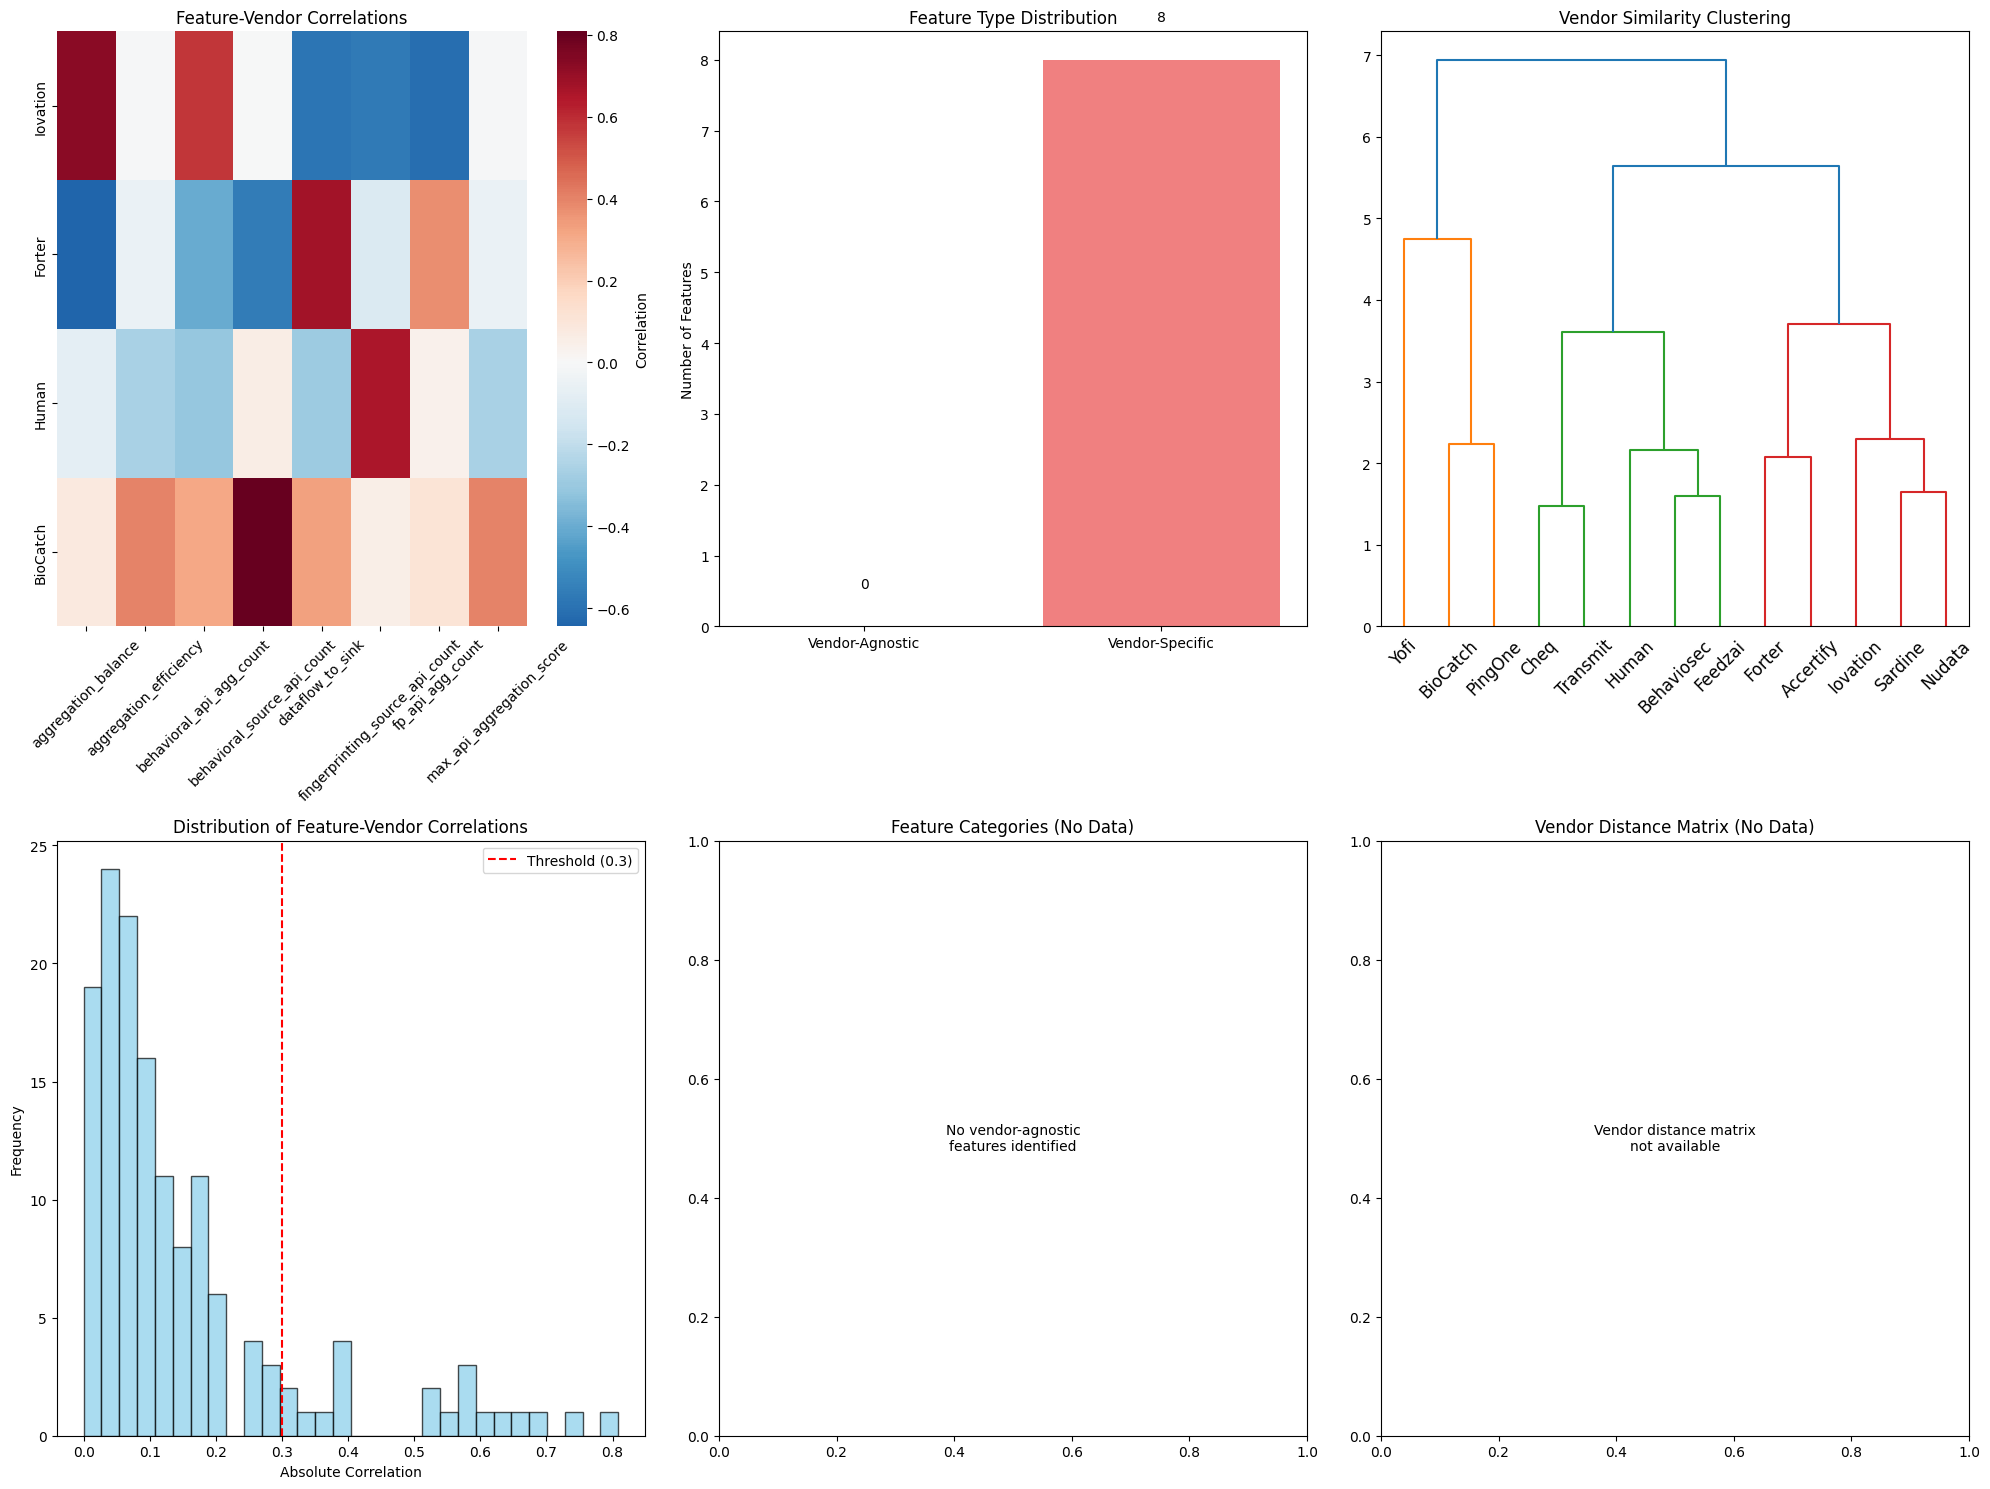

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage


# Cell 5: Visualization of Feature Analysis (UPDATED)
def create_feature_analysis_plots(vendor_correlations, vendor_agnostic, vendor_specific, 
                                vendor_profiles, vendor_names, linkage_matrix):
    """
    Create comprehensive visualizations for feature analysis
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Feature correlation heatmap for major vendors
    ax1 = plt.subplot(2, 3, 1)
    major_vendors = ['Iovation', 'Forter', 'Human', 'BioCatch']
    
    # Create correlation matrix for top features of major vendors
    top_features_per_vendor = {}
    for vendor in major_vendors:
        if vendor in vendor_correlations:
            top_features_per_vendor[vendor] = vendor_correlations[vendor].head(8)['feature'].tolist()
    
    # Get unique top features
    all_top_features = set()
    for features_list in top_features_per_vendor.values():
        all_top_features.update(features_list)
    
    # Create heatmap data
    heatmap_data = []
    for vendor in major_vendors:
        if vendor in vendor_correlations:
            vendor_data = []
            for feature in sorted(all_top_features):
                corr_row = vendor_correlations[vendor][vendor_correlations[vendor]['feature'] == feature]
                if len(corr_row) > 0:
                    vendor_data.append(corr_row.iloc[0]['raw_correlation'])
                else:
                    vendor_data.append(0)
            heatmap_data.append(vendor_data)
    
    if heatmap_data and len(all_top_features) > 0:
        sns.heatmap(heatmap_data, xticklabels=sorted(all_top_features), yticklabels=major_vendors,
                   cmap='RdBu_r', center=0, ax=ax1, cbar_kws={'label': 'Correlation'})
        ax1.set_title('Feature-Vendor Correlations')
        ax1.tick_params(axis='x', rotation=45)
    else:
        ax1.text(0.5, 0.5, 'No correlation data available', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Feature-Vendor Correlations (No Data)')
    
    # 2. Vendor-agnostic vs vendor-specific feature counts
    ax2 = plt.subplot(2, 3, 2)
    if len(vendor_agnostic) > 0 or len(vendor_specific) > 0:
        feature_types = ['Vendor-Agnostic', 'Vendor-Specific']
        feature_counts = [len(vendor_agnostic), len(vendor_specific)]
        colors = ['lightblue', 'lightcoral']
        
        bars = ax2.bar(feature_types, feature_counts, color=colors)
        ax2.set_title('Feature Type Distribution')
        ax2.set_ylabel('Number of Features')
        
        # Add count labels on bars
        for bar, count in zip(bars, feature_counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{count}', ha='center', va='bottom')
    else:
        ax2.text(0.5, 0.5, 'Feature classification\nnot yet available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Feature Type Distribution (No Data)')
    
    # 3. Vendor clustering dendrogram
    ax3 = plt.subplot(2, 3, 3)
    if linkage_matrix is not None and len(vendor_names) > 1:
        dendrogram(linkage_matrix, labels=vendor_names, ax=ax3, orientation='top')
        ax3.set_title('Vendor Similarity Clustering')
        ax3.tick_params(axis='x', rotation=45)
    else:
        ax3.text(0.5, 0.5, 'Vendor clustering\nnot available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Vendor Similarity Clustering (No Data)')
    
    # 4. Distribution of correlation strengths
    ax4 = plt.subplot(2, 3, 4)
    all_correlations = []
    for vendor, corr_df in vendor_correlations.items():
        all_correlations.extend(corr_df['correlation'].tolist())
    
    if len(all_correlations) > 0:
        ax4.hist(all_correlations, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax4.axvline(x=0.3, color='red', linestyle='--', label='Threshold (0.3)')
        ax4.set_title('Distribution of Feature-Vendor Correlations')
        ax4.set_xlabel('Absolute Correlation')
        ax4.set_ylabel('Frequency')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'No correlation data\navailable', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlation Distribution (No Data)')
    
    # 5. Feature importance by category
    ax5 = plt.subplot(2, 3, 5)
    if len(vendor_agnostic) > 0:
        feature_categories = {
            'behavioral': [f for f in vendor_agnostic if 'behavioral' in f],
            'fingerprint': [f for f in vendor_agnostic if 'fp_' in f],
            'sophistication': [f for f in vendor_agnostic if 'sophistication' in f],
            'ratio': [f for f in vendor_agnostic if 'ratio' in f],
            'entropy': [f for f in vendor_agnostic if 'entropy' in f or 'gini' in f],
            'other': [f for f in vendor_agnostic if not any(cat in f for cat in ['behavioral', 'fp_', 'sophistication', 'ratio', 'entropy', 'gini'])]
        }
        
        category_counts = {cat: len(features) for cat, features in feature_categories.items() if len(features) > 0}
        
        if len(category_counts) > 0:
            ax5.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%')
            ax5.set_title('Vendor-Agnostic Features by Category')
        else:
            ax5.text(0.5, 0.5, 'No categorized features\navailable', ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Feature Categories (No Data)')
    else:
        ax5.text(0.5, 0.5, 'No vendor-agnostic\nfeatures identified', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Feature Categories (No Data)')
    
    # 6. Vendor similarity heatmap
    ax6 = plt.subplot(2, 3, 6)
    if vendor_profiles is not None and len(vendor_names) <= 10:
        sns.heatmap(distance_matrix, xticklabels=vendor_names, yticklabels=vendor_names,
                   cmap='viridis', ax=ax6, cbar_kws={'label': 'Distance'})
        ax6.set_title('Vendor Distance Matrix')
        ax6.tick_params(axis='x', rotation=45)
        ax6.tick_params(axis='y', rotation=0)
    else:
        ax6.text(0.5, 0.5, 'Vendor distance matrix\nnot available', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Vendor Distance Matrix (No Data)')
    
    plt.tight_layout()
    plt.show()

# Create all visualizations
create_feature_analysis_plots(vendor_correlations, vendor_agnostic, vendor_specific,
                            vendor_profiles, vendor_names, linkage_matrix)

In [23]:
# Cell 6: Feature Recommendation Summary
print("\n" + "="*60)
print("FEATURE ENGINEERING RECOMMENDATIONS")
print("="*60)

print(f"\n1. FEATURE PORTFOLIO:")
print(f"   - Total features: {len(feature_cols)}")
print(f"   - Vendor-agnostic: {len(vendor_agnostic)} ({len(vendor_agnostic)/len(feature_cols)*100:.1f}%)")
print(f"   - Vendor-specific: {len(vendor_specific)} ({len(vendor_specific)/len(feature_cols)*100:.1f}%)")

print(f"\n2. TOP VENDOR-AGNOSTIC FEATURES (for generalization):")
for i, feature in enumerate(vendor_agnostic[:10], 1):
    print(f"   {i:2d}. {feature}")

print(f"\n3. VENDOR SIMILARITY INSIGHTS:")
if vendor_profiles is not None:
    # Find most similar vendor pairs
    n_vendors = len(vendor_names)
    if n_vendors > 1:
        min_distance_idx = np.unravel_index(
            np.argmin(distance_matrix + np.eye(n_vendors) * 1000), 
            distance_matrix.shape
        )
        most_similar = (vendor_names[min_distance_idx[0]], vendor_names[min_distance_idx[1]])
        print(f"   - Most similar vendors: {most_similar[0]} & {most_similar[1]}")
        
        # Find most different vendor pairs
        max_distance_idx = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
        most_different = (vendor_names[max_distance_idx[0]], vendor_names[max_distance_idx[1]])
        print(f"   - Most different vendors: {most_different[0]} & {most_different[1]}")

print(f"\n4. NEXT STEPS:")
print(f"   - Focus training on vendor-agnostic features")
print(f"   - Consider removing highly vendor-specific features")
print(f"   - Use vendor similarity for smarter train/test splits")
print(f"   - Explore feature interactions between agnostic features")


FEATURE ENGINEERING RECOMMENDATIONS

1. FEATURE PORTFOLIO:
   - Total features: 52
   - Vendor-agnostic: 0 (0.0%)
   - Vendor-specific: 8 (15.4%)

2. TOP VENDOR-AGNOSTIC FEATURES (for generalization):

3. VENDOR SIMILARITY INSIGHTS:
   - Most similar vendors: Cheq & Transmit
   - Most different vendors: Accertify & Yofi

4. NEXT STEPS:
   - Focus training on vendor-agnostic features
   - Consider removing highly vendor-specific features
   - Use vendor similarity for smarter train/test splits
   - Explore feature interactions between agnostic features


In [24]:
# Fixed Cell: Proper handling of pandas arrays in pd.isna()
def create_working_vendor_agnostic_features(df):
    """
    Create vendor-agnostic features with proper handling of pandas list fields
    """
    features_list = []
    
    def is_null_or_empty(value):
        """Properly check if a value is null/empty, handling pandas arrays"""
        if value is None:
            return True
        try:
            # For pandas arrays, check if all elements are null
            if hasattr(value, '__len__') and not isinstance(value, (str, dict)):
                if len(value) == 0:
                    return True
                # Check if it's a pandas null check result array
                if hasattr(value, 'dtype') and 'bool' in str(value.dtype):
                    return False  # It's a boolean array from pd.isna(), so original value exists
                return False
            return pd.isna(value)
        except:
            return value is None
    
    for idx, row in df.iterrows():
        try:
            features = {}
            
            # Safe extraction without pd.isna() on lists
            behavioral_access = row['behavioral_apis_access_count'] if row['behavioral_apis_access_count'] is not None else {}
            fp_access = row['fingerprinting_api_access_count'] if row['fingerprinting_api_access_count'] is not None else {}
            behavioral_sources = row['behavioral_source_apis'] if row['behavioral_source_apis'] is not None else []
            fp_sources = row['fingerprinting_source_apis'] if row['fingerprinting_source_apis'] is not None else []
            sink_data = row['apis_going_to_sink'] if row['apis_going_to_sink'] is not None else {}
            
            # === VENDOR-AGNOSTIC BEHAVIORAL PATTERNS ===
            
            # 1. RELATIVE COMPLEXITY
            total_behavioral = len(behavioral_sources) if behavioral_sources is not None else 0
            total_fp = len(fp_sources) if fp_sources is not None else 0
            total_apis = total_behavioral + total_fp
            
            if total_apis > 0:
                features['behavioral_focus_ratio'] = total_behavioral / total_apis
                features['fp_focus_ratio'] = total_fp / total_apis
            else:
                features['behavioral_focus_ratio'] = 0
                features['fp_focus_ratio'] = 0
            
            # 2. INTERACTION PATTERN DIVERSITY
            event_types = set()
            if behavioral_sources is not None:
                for api in behavioral_sources:
                    api_str = str(api)
                    if 'MouseEvent' in api_str:
                        event_types.add('mouse')
                    elif 'KeyboardEvent' in api_str:
                        event_types.add('keyboard')
                    elif 'TouchEvent' in api_str or 'Touch.' in api_str:
                        event_types.add('touch')
                    elif 'PointerEvent' in api_str:
                        event_types.add('pointer')
                    elif 'DeviceMotion' in api_str or 'DeviceOrientation' in api_str:
                        event_types.add('device')
                    elif 'WheelEvent' in api_str:
                        event_types.add('wheel')
                    elif 'FocusEvent' in api_str:
                        event_types.add('focus')
            
            features['interaction_diversity'] = len(event_types)
            features['has_multi_input_types'] = int(len(event_types) >= 3)
            
            # 3. SOPHISTICATION PATTERNS
            coordinate_apis = 0
            timing_apis = 0
            device_apis = 0
            
            if behavioral_sources is not None:
                for api in behavioral_sources:
                    api_str = str(api)
                    if any(coord in api_str for coord in ['clientX', 'clientY', 'screenX', 'screenY', 'pageX', 'pageY']):
                        coordinate_apis += 1
                    if any(timing in api_str for timing in ['timeStamp', 'interval']):
                        timing_apis += 1
                    if 'DeviceMotion' in api_str or 'DeviceOrientation' in api_str:
                        device_apis += 1
            
            features['tracks_coordinates'] = int(coordinate_apis > 0)
            features['tracks_timing'] = int(timing_apis > 0)
            features['tracks_device_motion'] = int(device_apis > 0)
            features['sophistication_score'] = features['tracks_coordinates'] + features['tracks_timing'] + features['tracks_device_motion']
            
            # 4. FINGERPRINTING CATEGORIES
            navigator_apis = 0
            screen_apis = 0
            canvas_apis = 0
            audio_apis = 0
            
            if fp_sources is not None:
                for api in fp_sources:
                    api_str = str(api)
                    if 'Navigator.' in api_str:
                        navigator_apis += 1
                    if 'Screen.' in api_str:
                        screen_apis += 1
                    if 'Canvas' in api_str or 'WebGL' in api_str:
                        canvas_apis += 1
                    if 'Audio' in api_str:
                        audio_apis += 1
            
            features['uses_navigator_fp'] = int(navigator_apis > 0)
            features['uses_screen_fp'] = int(screen_apis > 0)
            features['uses_canvas_fp'] = int(canvas_apis > 0)
            features['uses_audio_fp'] = int(audio_apis > 0)
            features['fp_approach_diversity'] = features['uses_navigator_fp'] + features['uses_screen_fp'] + features['uses_canvas_fp'] + features['uses_audio_fp']
            
            # 5. ACCESS INTENSITY
            total_behavioral_accesses = sum(behavioral_access.values()) if behavioral_access else 0
            total_fp_accesses = sum(fp_access.values()) if fp_access else 0
            total_accesses = total_behavioral_accesses + total_fp_accesses
            
            features['collection_intensity'] = total_accesses / max(total_apis, 1)
            features['behavioral_access_ratio'] = total_behavioral_accesses / max(total_accesses, 1) if total_accesses > 0 else 0
            
            # 6. DATA FLOW PATTERNS
            features['has_data_collection'] = int(len(sink_data) > 0) if sink_data else 0
            features['collection_method_diversity'] = len(sink_data) if sink_data else 0
            
            # 7. BINARY TRACKING CAPABILITIES
            features['tracks_mouse'] = int(any('MouseEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_keyboard'] = int(any('KeyboardEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_touch'] = int(any('TouchEvent' in str(api) or 'Touch.' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['tracks_pointer'] = int(any('PointerEvent' in str(api) for api in behavioral_sources)) if behavioral_sources else 0
            features['performs_fingerprinting'] = int(len(fp_sources) > 0) if fp_sources else 0
            
            # 8. COMPLEXITY CLASSIFICATION
            if total_apis == 0:
                features['complexity_tier'] = 0
            elif total_apis <= 5:
                features['complexity_tier'] = 1
            elif total_apis <= 15:
                features['complexity_tier'] = 2
            else:
                features['complexity_tier'] = 3
            
            # 9. BALANCE METRICS
            features['is_behavioral_heavy'] = int(total_behavioral > total_fp and total_behavioral > 5)
            features['is_fp_heavy'] = int(total_fp > total_behavioral and total_fp > 5)
            features['is_balanced_tracker'] = int(abs(total_behavioral - total_fp) <= 3 and total_apis > 5)
            
            # Store metadata (these are simple types, no array issues)
            features['script_id'] = int(row['script_id'])
            features['label'] = int(row['label'])
            features['vendor'] = row['vendor'] if row['vendor'] is not None else 'negative'
            
            features_list.append(features)
            
        except Exception as e:
            print(f"Error processing script {row.get('script_id', 'unknown')}: {e}")
            continue
    
    return pd.DataFrame(features_list)

# Create the working features
print("Creating vendor-agnostic features (fixed version)...")
agnostic_features_df = create_working_vendor_agnostic_features(df)
feature_cols = [col for col in agnostic_features_df.columns if col not in ['script_id', 'label', 'vendor']]
print(f"Created {len(feature_cols)} vendor-agnostic features for {len(agnostic_features_df)} scripts")

# Check variance and distributions
print(f"\nFeature variance check:")
positive_samples = agnostic_features_df[agnostic_features_df['label'] == 1]
for col in feature_cols[:10]:
    if len(positive_samples) > 0:
        variance = positive_samples[col].var()
        unique_vals = positive_samples[col].nunique()
        mean_val = positive_samples[col].mean()
        print(f"{col}: mean={mean_val:.3f}, var={variance:.3f}, unique={unique_vals}")

# Compare positive vs negative
print(f"\nPositive vs Negative comparison:")
neg_samples = agnostic_features_df[agnostic_features_df['label'] == 0]
print("Feature | Pos_Mean | Neg_Mean | Difference")
print("-" * 50)
for col in feature_cols[:10]:
    if len(positive_samples) > 0 and len(neg_samples) > 0:
        pos_mean = positive_samples[col].mean()
        neg_mean = neg_samples[col].mean()
        diff = pos_mean - neg_mean
        print(f"{col[:20]:20} | {pos_mean:8.3f} | {neg_mean:8.3f} | {diff:10.3f}")

Creating vendor-agnostic features (fixed version)...
Created 26 vendor-agnostic features for 2229 scripts

Feature variance check:
behavioral_focus_ratio: mean=0.504, var=0.035, unique=94
fp_focus_ratio: mean=0.496, var=0.035, unique=94
interaction_diversity: mean=4.194, var=2.677, unique=7
has_multi_input_types: mean=0.737, var=0.195, unique=2
tracks_coordinates: mean=0.974, var=0.025, unique=2
tracks_timing: mean=0.741, var=0.193, unique=2
tracks_device_motion: mean=0.470, var=0.250, unique=2
sophistication_score: mean=2.185, var=0.671, unique=4
uses_navigator_fp: mean=0.996, var=0.004, unique=2
uses_screen_fp: mean=0.987, var=0.013, unique=2

Positive vs Negative comparison:
Feature | Pos_Mean | Neg_Mean | Difference
--------------------------------------------------
behavioral_focus_rat |    0.504 |    0.596 |     -0.092
fp_focus_ratio       |    0.496 |    0.404 |      0.092
interaction_diversit |    4.194 |    2.012 |      2.182
has_multi_input_type |    0.737 |    0.250 |      0

In [25]:
agnostic_features_df

,behavioral_focus_ratio,fp_focus_ratio,interaction_diversity,has_multi_input_types,tracks_coordinates,tracks_timing,tracks_device_motion,sophistication_score,uses_navigator_fp,uses_screen_fp,...,tracks_touch,tracks_pointer,performs_fingerprinting,complexity_tier,is_behavioral_heavy,is_fp_heavy,is_balanced_tracker,script_id,label,vendor
0,1.000000,0.000000,3,1,1,0,0,1,0,0,...,0,1,0,2,1,0,0,7392023,-1,negative
1,0.333333,0.666667,1,0,0,0,0,0,1,0,...,0,1,1,1,0,0,0,7392036,-1,negative
2,1.000000,0.000000,3,1,0,1,0,1,0,0,...,0,1,0,3,1,0,0,7392015,-1,negative
3,0.428571,0.571429,3,1,0,0,0,0,0,0,...,0,1,1,2,0,0,1,7392039,-1,negative
4,0.666667,0.333333,1,0,0,1,0,1,1,0,...,0,1,1,1,0,0,0,7392076,-1,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,0.527778,0.472222,3,1,1,1,1,3,1,1,...,1,0,1,3,1,0,1,7403607,1,Iovation
2225,0.217391,0.782609,2,0,1,0,0,1,1,1,...,0,1,1,3,0,1,0,7402719,1,Forter
2226,0.630435,0.369565,5,1,1,1,1,3,1,1,...,1,1,1,3,1,0,0,7406891,1,Iovation
2227,0.585366,0.414634,5,1,1,0,0,1,1,1,...,1,1,1,3,1,0,0,7394204,1,Iovation


In [28]:
# Cell: Truly Vendor-Agnostic Features (Take 2)
def create_truly_agnostic_features(df):
    """
    Create features based on fundamental behavioral biometric concepts,
    not implementation details
    """
    features_list = []
    
    for idx, row in df.iterrows():
        try:
            features = {}
            
            # Safe data extraction
            behavioral_access = row['behavioral_apis_access_count'] if row['behavioral_apis_access_count'] is not None else {}
            fp_access = row['fingerprinting_api_access_count'] if row['fingerprinting_api_access_count'] is not None else {}
            behavioral_sources = row['behavioral_source_apis'] if row['behavioral_source_apis'] is not None else []
            fp_sources = row['fingerprinting_source_apis'] if row['fingerprinting_source_apis'] is not None else []
            sink_data = row['apis_going_to_sink'] if row['apis_going_to_sink'] is not None else {}
            
            # === FUNDAMENTAL BEHAVIORAL BIOMETRIC CONCEPTS ===
            
            # 1. HAS ANY USER INTERACTION TRACKING
            has_user_interaction = any(any(event in str(api) for event in ['MouseEvent', 'KeyboardEvent', 'TouchEvent', 'PointerEvent', 'Touch.']) 
                                     for api in behavioral_sources)
            features['monitors_user_interaction'] = int(has_user_interaction)
            
            # 2. HAS ANY DEVICE FINGERPRINTING  
            has_device_fp = len(fp_sources) > 0
            features['performs_device_fingerprinting'] = int(has_device_fp)
            
            # 3. HAS ANY DATA COLLECTION
            has_data_flow = len(sink_data) > 0
            features['collects_data'] = int(has_data_flow)
            
            # 4. INTERACTION + FINGERPRINTING COMBINATION
            features['is_hybrid_system'] = int(has_user_interaction and has_device_fp)
            features['is_interaction_only'] = int(has_user_interaction and not has_device_fp)
            features['is_fingerprint_only'] = int(not has_user_interaction and has_device_fp)
            
            # 5. RELATIVE COMPLEXITY (TIERS, NOT ABSOLUTE NUMBERS)
            total_behavioral = len(behavioral_sources)
            total_fp = len(fp_sources)
            total_apis = total_behavioral + total_fp
            
            # Complexity based on percentiles, not absolute values
            if total_apis == 0:
                features['complexity_percentile'] = 0
            elif total_apis <= 5:
                features['complexity_percentile'] = 25  # Bottom quartile
            elif total_apis <= 15:
                features['complexity_percentile'] = 50  # Middle
            elif total_apis <= 30:
                features['complexity_percentile'] = 75  # Upper quartile
            else:
                features['complexity_percentile'] = 90  # Top decile
            
            # 6. DATA COLLECTION PATTERNS (BINARY INDICATORS)
            features['uses_persistent_storage'] = int(any('Storage' in str(sink) for sink in sink_data.keys()))
            features['sends_network_data'] = int(any(net in str(sink) for net in ['XMLHttpRequest', 'fetch', 'sendBeacon'] for sink in sink_data.keys()))
            features['manipulates_dom'] = int(any(dom in str(sink) for dom in ['innerHTML', 'appendChild'] for sink in sink_data.keys()))
            
            # 7. BEHAVIORAL BIOMETRIC INDICATORS (BINARY)
            features['tracks_movement_precision'] = int(any(precision in str(api) for precision in ['clientX', 'clientY', 'screenX', 'screenY'] for api in behavioral_sources))
            features['tracks_timing_patterns'] = int(any('timeStamp' in str(api) for api in behavioral_sources))
            features['tracks_pressure_force'] = int(any(pressure in str(api) for pressure in ['pressure', 'force'] for api in behavioral_sources))
            
            # 8. ADVANCED FINGERPRINTING INDICATORS (BINARY)
            features['uses_advanced_fingerprinting'] = int(any(advanced in str(api) for advanced in ['Canvas', 'WebGL', 'Audio'] for api in fp_sources))
            features['collects_hardware_details'] = int(any(hardware in str(api) for hardware in ['hardwareConcurrency', 'deviceMemory'] for api in fp_sources))
            
            # 9. SCRIPT BEHAVIOR CLASSIFICATION
            # Based on fundamental purpose, not implementation
            if has_user_interaction and has_device_fp and has_data_flow:
                features['script_archetype'] = 3  # Full behavioral biometric system
            elif has_user_interaction and has_data_flow:
                features['script_archetype'] = 2  # Behavioral tracker
            elif has_device_fp:
                features['script_archetype'] = 1  # Fingerprinting only  
            else:
                features['script_archetype'] = 0  # No tracking
            
            # 10. IMPLEMENTATION COMPLEXITY (RELATIVE)
            # Avoid absolute counts that vary by vendor
            if total_apis > 0:
                access_intensity = (sum(behavioral_access.values()) + sum(fp_access.values())) / total_apis
                if access_intensity < 1.5:
                    features['implementation_intensity'] = 1  # Light
                elif access_intensity < 3.0:
                    features['implementation_intensity'] = 2  # Moderate
                else:
                    features['implementation_intensity'] = 3  # Heavy
            else:
                features['implementation_intensity'] = 0
            
            # Store metadata
            features['script_id'] = int(row['script_id'])
            features['label'] = int(row['label'])
            features['vendor'] = row['vendor'] if row['vendor'] is not None else 'negative'
            
            features_list.append(features)
            
        except Exception as e:
            print(f"Error processing script {row.get('script_id', 'unknown')}: {e}")
            continue
    
    return pd.DataFrame(features_list)

# Create truly agnostic features
print("Creating truly vendor-agnostic features (attempt 2)...")
truly_agnostic_df = create_truly_agnostic_features(df)
feature_cols = [col for col in truly_agnostic_df.columns if col not in ['script_id', 'label', 'vendor']]
print(f"Created {len(feature_cols)} features for {len(truly_agnostic_df)} scripts")

# Test these for vendor correlation immediately
print("\nTesting new features for vendor correlation...")
new_correlation_results, _, _ = test_vendor_agnostic_correlation(truly_agnostic_df, threshold=0.3)

print(f"\n=== IMPROVEMENT CHECK ===")
agnostic_count = (new_correlation_results['max_correlation'] < 0.3).sum()
total_count = len(new_correlation_results)
print(f"Vendor-agnostic features: {agnostic_count}/{total_count} ({agnostic_count/total_count*100:.1f}%)")

if agnostic_count > 1:  # If we improved
    print("✅ IMPROVEMENT! More features are vendor-agnostic")
    print("\nTop vendor-agnostic features:")
    agnostic_features = new_correlation_results[new_correlation_results['max_correlation'] < 0.3]
    for _, row in agnostic_features.iterrows():
        print(f"   {row['feature']}: max correlation = {row['max_correlation']:.3f}")
else:
    print("❌ Still need more work on vendor-agnostic design")

Creating truly vendor-agnostic features (attempt 2)...
Created 17 features for 2229 scripts

Testing new features for vendor correlation...
=== TESTING VENDOR CORRELATION OF NEW FEATURES ===
Testing 17 features against 18 vendors
Correlation threshold: 0.3

=== CORRELATION ANALYSIS RESULTS ===
Features with max correlation < 0.3: 6/17 (35.3%)
Features with max correlation >= 0.3: 11/17 (64.7%)

⚠️  VENDOR-SPECIFIC FEATURES (correlation >= 0.3):
   sends_network_data: 0.965 (worst: Forter)
   uses_persistent_storage: 0.911 (worst: Forter)
   implementation_intensity: 0.739 (worst: Forter)
   collects_data: 0.677 (worst: Forter)
   script_archetype: 0.677 (worst: Forter)
   collects_hardware_details: 0.669 (worst: Nudata)
   tracks_pressure_force: 0.612 (worst: BioCatch)
   tracks_timing_patterns: 0.604 (worst: Iovation)
   complexity_percentile: 0.530 (worst: Forter)
   tracks_movement_precision: 0.529 (worst: Transmit)
   uses_advanced_fingerprinting: 0.374 (worst: Sardine)

✅ TRULY VE

In [29]:
# Cell: Test Vendor Correlation of New Features
def test_vendor_agnostic_correlation(features_df, threshold=0.3):
    """
    Rigorously test if features are truly vendor-agnostic
    """
    print("=== TESTING VENDOR CORRELATION OF NEW FEATURES ===")
    
    # Only analyze positive samples (with vendor info)
    positive_features = features_df[features_df['label'] == 1].copy()
    
    # Get our new feature columns
    feature_cols = [col for col in features_df.columns if col not in ['script_id', 'label', 'vendor']]
    
    # One-hot encode vendors for correlation analysis
    vendor_dummies = pd.get_dummies(positive_features['vendor'], prefix='vendor')
    
    print(f"Testing {len(feature_cols)} features against {len(vendor_dummies.columns)} vendors")
    print(f"Correlation threshold: {threshold}")
    
    # Calculate correlations
    correlations_matrix = []
    feature_vendor_pairs = []
    
    for feature in feature_cols:
        feature_correlations = []
        max_correlation = 0
        max_vendor = ""
        
        for vendor_col in vendor_dummies.columns:
            vendor_name = vendor_col.replace('vendor_', '')
            
            # Calculate correlation
            corr = positive_features[feature].corr(vendor_dummies[vendor_col])
            if not np.isnan(corr):
                feature_correlations.append(abs(corr))
                if abs(corr) > max_correlation:
                    max_correlation = abs(corr)
                    max_vendor = vendor_name
            else:
                feature_correlations.append(0)
        
        correlations_matrix.append(feature_correlations)
        feature_vendor_pairs.append({
            'feature': feature,
            'max_correlation': max_correlation,
            'worst_vendor': max_vendor,
            'avg_correlation': np.mean(feature_correlations),
            'is_vendor_agnostic': max_correlation < threshold
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(feature_vendor_pairs).sort_values('max_correlation', ascending=False)
    
    # Summary statistics
    truly_agnostic = results_df[results_df['is_vendor_agnostic'] == True]
    vendor_specific = results_df[results_df['is_vendor_agnostic'] == False]
    
    print(f"\n=== CORRELATION ANALYSIS RESULTS ===")
    print(f"Features with max correlation < {threshold}: {len(truly_agnostic)}/{len(results_df)} ({len(truly_agnostic)/len(results_df)*100:.1f}%)")
    print(f"Features with max correlation >= {threshold}: {len(vendor_specific)}/{len(results_df)} ({len(vendor_specific)/len(results_df)*100:.1f}%)")
    
    if len(vendor_specific) > 0:
        print(f"\n⚠️  VENDOR-SPECIFIC FEATURES (correlation >= {threshold}):")
        for _, row in vendor_specific.iterrows():
            print(f"   {row['feature']}: {row['max_correlation']:.3f} (worst: {row['worst_vendor']})")
    
    if len(truly_agnostic) > 0:
        print(f"\n✅ TRULY VENDOR-AGNOSTIC FEATURES (correlation < {threshold}):")
        for _, row in truly_agnostic.head(10).iterrows():
            print(f"   {row['feature']}: {row['max_correlation']:.3f} (avg: {row['avg_correlation']:.3f})")
    
    return results_df, correlations_matrix, vendor_dummies.columns.tolist()

# Test our new features
correlation_results, corr_matrix, vendor_names = test_vendor_agnostic_correlation(agnostic_features_df, threshold=0.3)

# Detailed analysis of top features by importance
print(f"\n=== ANALYSIS OF TOP IMPORTANT FEATURES ===")
top_important_features = ['fp_approach_diversity', 'uses_canvas_fp', 'tracks_coordinates', 'collection_intensity', 'complexity_tier']

for feature in top_important_features:
    if feature in correlation_results['feature'].values:
        row = correlation_results[correlation_results['feature'] == feature].iloc[0]
        status = "✅ VENDOR-AGNOSTIC" if row['is_vendor_agnostic'] else "⚠️  VENDOR-SPECIFIC"
        print(f"{feature}: {status}")
        print(f"   Max correlation: {row['max_correlation']:.3f} (with {row['worst_vendor']})")
        print(f"   Avg correlation: {row['avg_correlation']:.3f}")
        
        # Show vendor-wise distribution for this feature
        positive_samples = agnostic_features_df[agnostic_features_df['label'] == 1]
        vendor_stats = positive_samples.groupby('vendor')[feature].agg(['mean', 'std']).round(3)
        print(f"   Vendor variation:")
        print(f"     Min mean: {vendor_stats['mean'].min():.3f}")
        print(f"     Max mean: {vendor_stats['mean'].max():.3f}")
        print(f"     Range: {vendor_stats['mean'].max() - vendor_stats['mean'].min():.3f}")
        print()

=== TESTING VENDOR CORRELATION OF NEW FEATURES ===
Testing 26 features against 18 vendors
Correlation threshold: 0.3

=== CORRELATION ANALYSIS RESULTS ===
Features with max correlation < 0.3: 1/26 (3.8%)
Features with max correlation >= 0.3: 25/26 (96.2%)

⚠️  VENDOR-SPECIFIC FEATURES (correlation >= 0.3):
   has_multi_input_types: 0.911 (worst: Forter)
   tracks_keyboard: 0.891 (worst: Forter)
   collection_method_diversity: 0.824 (worst: Forter)
   behavioral_access_ratio: 0.784 (worst: Forter)
   collection_intensity: 0.766 (worst: Forter)
   interaction_diversity: 0.738 (worst: Forter)
   fp_focus_ratio: 0.724 (worst: Forter)
   behavioral_focus_ratio: 0.724 (worst: Forter)
   tracks_device_motion: 0.706 (worst: Iovation)
   uses_screen_fp: 0.702 (worst: Sardine)
   tracks_touch: 0.683 (worst: Forter)
   has_data_collection: 0.677 (worst: Forter)
   is_fp_heavy: 0.653 (worst: Iovation)
   is_behavioral_heavy: 0.653 (worst: Iovation)
   sophistication_score: 0.641 (worst: Iovation)


=== FEATURE VARIANCE ANALYSIS ===
Analyzing 26 features across 232 positive samples

Features with ZERO variance: 1
                feature  mean  unique_values
performs_fingerprinting   1.0              1

Features with LOW variance (0 < std < 0.1): 2
          feature    mean      std  unique_values
uses_navigator_fp 0.99569 0.065653              2
  complexity_tier 2.99569 0.065653              2

Features with GOOD variance (std >= 0.1): 23
                    feature     mean      std      min      max
     behavioral_focus_ratio 0.503982 0.188196 0.052632 0.842105
             fp_focus_ratio 0.496018 0.188196 0.157895 0.947368
      interaction_diversity 4.193966 1.636001 1.000000 7.000000
      has_multi_input_types 0.737069 0.441177 0.000000 1.000000
         tracks_coordinates 0.974138 0.159067 0.000000 1.000000
              tracks_timing 0.741379 0.438823 0.000000 1.000000
       tracks_device_motion 0.469828 0.500168 0.000000 1.000000
       sophistication_score 2.185345 0.

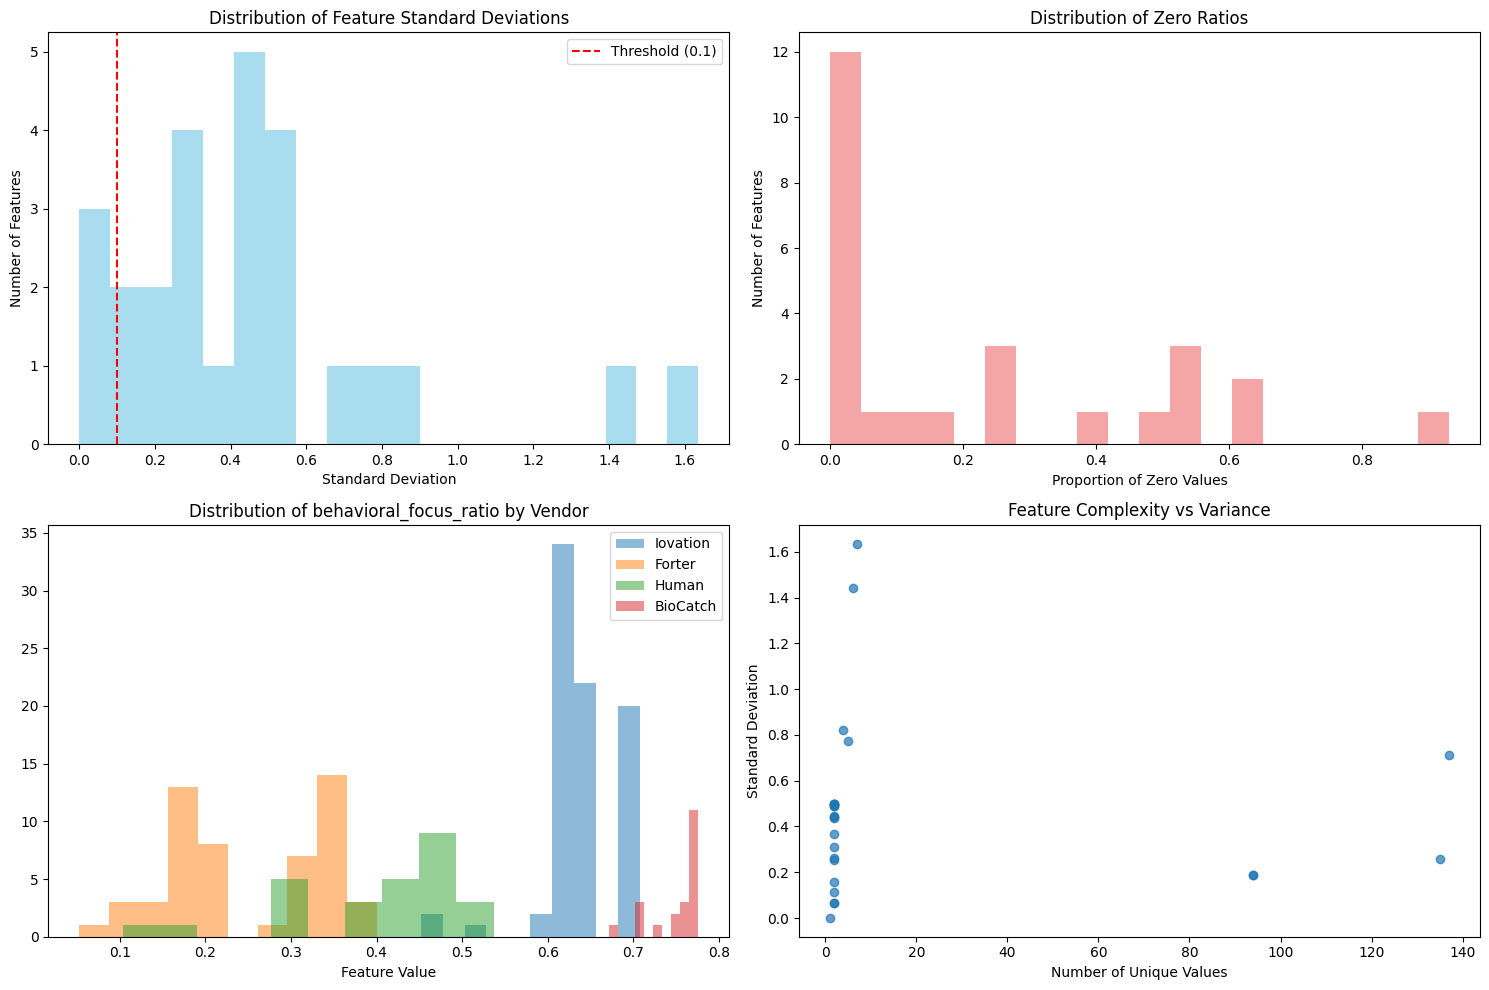


=== SUMMARY ===
Total features: 26
Zero variance: 1 (3.8%)
Low variance: 2 (7.7%)
Good variance: 23 (88.5%)


In [32]:
# Diagnostic Cell: Investigate the New Features
print("=== FEATURE VARIANCE ANALYSIS ===")

# Check feature distributions
feature_cols = [col for col in agnostic_features_df.columns if col not in ['script_id', 'label', 'vendor']]
positive_samples = agnostic_features_df[agnostic_features_df['label'] == 1]

print(f"Analyzing {len(feature_cols)} features across {len(positive_samples)} positive samples")

# Check each feature's variance and distribution
feature_stats = []
for feature in feature_cols:
    values = positive_samples[feature]
    stats = {
        'feature': feature,
        'mean': values.mean(),
        'std': values.std(),
        'min': values.min(),
        'max': values.max(),
        'unique_values': values.nunique(),
        'zero_ratio': (values == 0).mean()
    }
    feature_stats.append(stats)

feature_stats_df = pd.DataFrame(feature_stats)

# Show features with no variance (std = 0)
no_variance = feature_stats_df[feature_stats_df['std'] == 0]
print(f"\nFeatures with ZERO variance: {len(no_variance)}")
if len(no_variance) > 0:
    print(no_variance[['feature', 'mean', 'unique_values']].to_string(index=False))

# Show features with low variance
low_variance = feature_stats_df[(feature_stats_df['std'] > 0) & (feature_stats_df['std'] < 0.1)]
print(f"\nFeatures with LOW variance (0 < std < 0.1): {len(low_variance)}")
if len(low_variance) > 0:
    print(low_variance[['feature', 'mean', 'std', 'unique_values']].to_string(index=False))

# Show features with good variance
good_variance = feature_stats_df[feature_stats_df['std'] >= 0.1]
print(f"\nFeatures with GOOD variance (std >= 0.1): {len(good_variance)}")
if len(good_variance) > 0:
    print(good_variance[['feature', 'mean', 'std', 'min', 'max']].to_string(index=False))

# Check distribution by vendor for features with good variance
if len(good_variance) > 0:
    print(f"\n=== VENDOR-WISE DISTRIBUTION FOR GOOD FEATURES ===")
    
    good_features = good_variance['feature'].tolist()[:5]  # Check top 5
    
    for feature in good_features:
        print(f"\n{feature}:")
        vendor_stats = positive_samples.groupby('vendor')[feature].agg(['mean', 'std', 'count'])
        print(vendor_stats.round(3))

# Create visualization of feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Feature variance distribution
axes[0,0].hist(feature_stats_df['std'], bins=20, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Feature Standard Deviations')
axes[0,0].set_xlabel('Standard Deviation')
axes[0,0].set_ylabel('Number of Features')
axes[0,0].axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
axes[0,0].legend()

# 2. Zero ratio distribution
axes[0,1].hist(feature_stats_df['zero_ratio'], bins=20, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Distribution of Zero Ratios')
axes[0,1].set_xlabel('Proportion of Zero Values')
axes[0,1].set_ylabel('Number of Features')

# 3. Feature value distributions for good features
if len(good_variance) > 0:
    good_feature = good_variance.iloc[0]['feature']
    for i, vendor in enumerate(['Iovation', 'Forter', 'Human', 'BioCatch']):
        if vendor in positive_samples['vendor'].values:
            vendor_data = positive_samples[positive_samples['vendor'] == vendor][good_feature]
            axes[1,0].hist(vendor_data, alpha=0.5, label=vendor, bins=10)
    axes[1,0].set_title(f'Distribution of {good_feature} by Vendor')
    axes[1,0].set_xlabel('Feature Value')
    axes[1,0].legend()
else:
    axes[1,0].text(0.5, 0.5, 'No features with\ngood variance', ha='center', va='center', transform=axes[1,0].transAxes)

# 4. Unique values vs variance
axes[1,1].scatter(feature_stats_df['unique_values'], feature_stats_df['std'], alpha=0.7)
axes[1,1].set_xlabel('Number of Unique Values')
axes[1,1].set_ylabel('Standard Deviation')
axes[1,1].set_title('Feature Complexity vs Variance')

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"Total features: {len(feature_stats_df)}")
print(f"Zero variance: {len(no_variance)} ({len(no_variance)/len(feature_stats_df)*100:.1f}%)")
print(f"Low variance: {len(low_variance)} ({len(low_variance)/len(feature_stats_df)*100:.1f}%)")
print(f"Good variance: {len(good_variance)} ({len(good_variance)/len(feature_stats_df)*100:.1f}%)")

In [33]:
# Cell: Test New Features with Vendor-Aware Training
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Use your existing vendor-aware split function with new features
train_idx, test_idx, split_info = create_vendor_aware_split(agnostic_features_df)

# Get features (exclude metadata)
feature_cols = [col for col in agnostic_features_df.columns if col not in ['script_id', 'label', 'vendor']]
X_train = agnostic_features_df.loc[train_idx, feature_cols]
y_train = agnostic_features_df.loc[train_idx, 'label']
X_test = agnostic_features_df.loc[test_idx, feature_cols]
y_test = agnostic_features_df.loc[test_idx, 'label']

print(f"Training with {len(feature_cols)} vendor-agnostic features")
print(f"Training set: {len(train_idx)} samples")
print(f"Test set: {len(test_idx)} samples")

# Create vendor weights for training
def create_vendor_weights_fixed(features_df, train_idx):
    """Create inverse frequency weights for positive vendors"""
    train_df = features_df.loc[train_idx]
    train_positives = train_df[train_df['label'] == 1]
    
    if len(train_positives) == 0:
        return np.ones(len(train_idx))
    
    vendor_counts = train_positives['vendor'].value_counts()
    vendor_weights = 1 / np.sqrt(vendor_counts)
    vendor_weights = vendor_weights / vendor_weights.sum() * len(vendor_weights)
    
    sample_weights = np.ones(len(train_idx))
    for i, idx in enumerate(train_idx):
        row = features_df.loc[idx]
        if row['label'] == 1 and row['vendor'] in vendor_weights:
            sample_weights[i] = vendor_weights[row['vendor']]
    
    return sample_weights

# Get sample weights
sample_weights = create_vendor_weights_fixed(agnostic_features_df, train_idx)

# Train model with new features
rf_new = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_new.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions
y_pred = rf_new.predict(X_test)
y_pred_proba = rf_new.predict_proba(X_test)[:, 1]

print(f"\n=== NEW FEATURES PERFORMANCE ===")
print(f"Overall Accuracy: {rf_new.score(X_test, y_test):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Vendor-specific analysis
test_df = agnostic_features_df.loc[test_idx].copy()
test_df['predictions'] = y_pred
test_df['pred_proba'] = y_pred_proba

test_positives = test_df[test_df['label'] == 1]
if len(test_positives) > 0:
    print(f"\n=== VENDOR-SPECIFIC PERFORMANCE ===")
    
    vendor_performance = []
    for vendor in test_positives['vendor'].unique():
        vendor_data = test_positives[test_positives['vendor'] == vendor]
        accuracy = (vendor_data['predictions'] == vendor_data['label']).mean()
        count = len(vendor_data)
        
        # Determine vendor category
        if vendor in split_info['train_vendors']['high_volume_partial']:
            category = 'high (seen)'
        elif vendor in split_info['test_vendors']['medium_volume']:
            category = 'medium (unseen)'
        elif vendor in split_info['test_vendors']['low_volume']:
            category = 'low (unseen)'
        else:
            category = 'unknown'
        
        vendor_performance.append({
            'vendor': vendor,
            'accuracy': accuracy,
            'count': count,
            'category': category
        })
    
    vendor_perf_df = pd.DataFrame(vendor_performance).sort_values('accuracy', ascending=False)
    print(vendor_perf_df)
    
    # Category performance
    category_perf = vendor_perf_df.groupby('category').agg({
        'accuracy': 'mean',
        'count': 'sum'
    }).round(3)
    
    print(f"\n=== CATEGORY PERFORMANCE ===")
    print(category_perf)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_new.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low volume vendor 'Threatmark': 1 scripts -> all to train
Low volume vendor 'GroupIB': 1 scripts -> all to train
Low volume vendor 'Utarget': 1 scripts -> all to test
Low volume vendor 'Accertify': 3 scripts -> all to test
Low volume vendor 'Datadome': 1 scrip

In [34]:
# Cell: Filter to Binary Classification (0 and 1 only)
print("=== FILTERING TO BINARY CLASSIFICATION (0 and 1 only) ===")

# Filter out label -1, keep only 0 and 1
binary_df = agnostic_features_df[agnostic_features_df['label'].isin([0, 1])].copy()

print("Original dataset:")
print(f"  Total samples: {len(agnostic_features_df)}")
print(f"  Label distribution: {agnostic_features_df['label'].value_counts().to_dict()}")

print("\nFiltered binary dataset:")
print(f"  Total samples: {len(binary_df)}")
print(f"  Label distribution: {binary_df['label'].value_counts().to_dict()}")
print(f"  Positive rate: {(binary_df['label'] == 1).mean():.3f}")

# Re-run your vendor-aware analysis with binary data
train_idx_binary, test_idx_binary, split_info_binary = create_vendor_aware_split(binary_df)

X_train_binary = binary_df.loc[train_idx_binary, feature_cols]
y_train_binary = binary_df.loc[train_idx_binary, 'label']
X_test_binary = binary_df.loc[test_idx_binary, feature_cols]
y_test_binary = binary_df.loc[test_idx_binary, 'label']

print(f"\nBinary train/test split:")
print(f"  Training: {len(train_idx_binary)} samples")
print(f"  Test: {len(test_idx_binary)} samples")
print(f"  Train labels: {y_train_binary.value_counts().to_dict()}")
print(f"  Test labels: {y_test_binary.value_counts().to_dict()}")

# Train binary model
rf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_binary.fit(X_train_binary, y_train_binary)

# Predictions
y_pred_binary = rf_binary.predict(X_test_binary)
y_pred_proba_binary = rf_binary.predict_proba(X_test_binary)[:, 1]

print(f"\n=== BINARY CLASSIFICATION RESULTS ===")
print(f"Overall Accuracy: {rf_binary.score(X_test_binary, y_test_binary):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test_binary, y_pred_proba_binary):.3f}")

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

# Vendor-specific analysis for binary data
test_df_binary = binary_df.loc[test_idx_binary].copy()
test_df_binary['predictions'] = y_pred_binary
test_df_binary['pred_proba'] = y_pred_proba_binary

test_positives_binary = test_df_binary[test_df_binary['label'] == 1]
if len(test_positives_binary) > 0:
    print(f"\n=== VENDOR-SPECIFIC PERFORMANCE (Binary) ===")
    
    vendor_performance_binary = []
    for vendor in test_positives_binary['vendor'].unique():
        vendor_data = test_positives_binary[test_positives_binary['vendor'] == vendor]
        accuracy = (vendor_data['predictions'] == vendor_data['label']).mean()
        count = len(vendor_data)
        
        # Determine vendor category
        if vendor in split_info_binary['train_vendors']['high_volume_partial']:
            category = 'high (seen)'
        elif vendor in split_info_binary['test_vendors']['medium_volume']:
            category = 'medium (unseen)'
        elif vendor in split_info_binary['test_vendors']['low_volume']:
            category = 'low (unseen)'
        else:
            category = 'unknown'
        
        vendor_performance_binary.append({
            'vendor': vendor,
            'accuracy': accuracy,
            'count': count,
            'category': category
        })
    
    vendor_perf_df_binary = pd.DataFrame(vendor_performance_binary).sort_values('accuracy', ascending=False)
    print(vendor_perf_df_binary)
    
    # Category performance
    category_perf_binary = vendor_perf_df_binary.groupby('category').agg({
        'accuracy': 'mean',
        'count': 'sum'
    }).round(3)
    
    print(f"\n=== CATEGORY PERFORMANCE (Binary) ===")
    print(category_perf_binary)

# Now test CV on binary data
print(f"\n=== CROSS-VALIDATION ON BINARY DATA ===")
cv_scores_binary = cross_val_score(rf_binary, 
                                  binary_df[feature_cols], 
                                  binary_df['label'], 
                                  cv=5, scoring='accuracy')

cv_roc_binary = cross_val_score(rf_binary, 
                               binary_df[feature_cols], 
                               binary_df['label'], 
                               cv=5, scoring='roc_auc')

print(f"Standard CV (Binary): {cv_scores_binary.mean():.3f} ± {cv_scores_binary.std():.3f}")
print(f"ROC AUC CV (Binary):  {cv_roc_binary.mean():.3f} ± {cv_roc_binary.std():.3f}")

# Compare performance metrics
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Standard CV (binary data):     {cv_scores_binary.mean():.3f}")
print(f"Vendor-aware (binary data):    {rf_binary.score(X_test_binary, y_test_binary):.3f}")
print(f"Previous vendor-aware (3-class): 0.926")

gap = rf_binary.score(X_test_binary, y_test_binary) - cv_scores_binary.mean()
print(f"Vendor-aware improvement: +{gap:.3f}")

if gap > 0.05:
    print("✅ Vendor-aware splitting provides significant improvement!")
elif gap > 0.02:
    print("✅ Vendor-aware splitting provides modest improvement")
else:
    print("⚠️  Vendor-aware splitting may not be critical for this binary problem")

=== FILTERING TO BINARY CLASSIFICATION (0 and 1 only) ===
Original dataset:
  Total samples: 2229
  Label distribution: {-1: 1753, 0: 244, 1: 232}

Filtered binary dataset:
  Total samples: 476
  Label distribution: {0: 244, 1: 232}
  Positive rate: 0.487
Splitting 232 positives and 244 negatives...
High volume vendor 'Iovation': 81 scripts -> 57 train, 24 test
High volume vendor 'Forter': 53 scripts -> 38 train, 15 test
High volume vendor 'Human': 27 scripts -> 19 train, 8 test
High volume vendor 'BioCatch': 21 scripts -> 15 train, 6 test
Medium volume vendor 'PingOne': 5 scripts -> all to train
Medium volume vendor 'Nudata': 6 scripts -> all to train
Medium volume vendor 'Yofi': 8 scripts -> all to train
Medium volume vendor 'Sardine': 6 scripts -> all to test
Medium volume vendor 'Behaviosec': 9 scripts -> all to test
Low volume vendor 'Cheq': 4 scripts -> all to train
Low volume vendor 'Callsign': 1 scripts -> all to train
Low volume vendor 'Feedzai': 2 scripts -> all to train
Low 

In [35]:
# Cell: Investigate Why Standard CV is Better
print("=== INVESTIGATING WHY STANDARD CV PERFORMS BETTER ===")

# Let's see what happens in standard CV folds
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_binary = binary_df[feature_cols]
y_binary = binary_df['label']

fold_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_binary, y_binary)):
    
    # Get train/val data for this fold
    train_data = binary_df.iloc[train_idx]
    val_data = binary_df.iloc[val_idx]
    
    # Analyze vendor distribution in this fold
    train_positives = train_data[train_data['label'] == 1]
    val_positives = val_data[val_data['label'] == 1]
    
    train_vendors = set(train_positives['vendor'].dropna().unique())
    val_vendors = set(val_positives['vendor'].dropna().unique())
    
    # Check vendor overlap
    vendor_overlap = len(train_vendors.intersection(val_vendors))
    total_val_vendors = len(val_vendors)
    
    # Train and test this fold
    X_fold_train = X_binary.iloc[train_idx]
    y_fold_train = y_binary.iloc[train_idx]
    X_fold_val = X_binary.iloc[val_idx]
    y_fold_val = y_binary.iloc[val_idx]
    
    fold_model = RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, class_weight='balanced'
    )
    fold_model.fit(X_fold_train, y_fold_train)
    fold_accuracy = fold_model.score(X_fold_val, y_fold_val)
    
    fold_results.append({
        'fold': fold + 1,
        'accuracy': fold_accuracy,
        'train_vendors': len(train_vendors),
        'val_vendors': len(val_vendors),
        'vendor_overlap': vendor_overlap,
        'overlap_rate': vendor_overlap / max(total_val_vendors, 1),
        'train_pos': len(train_positives),
        'val_pos': len(val_positives)
    })
    
    print(f"Fold {fold + 1}:")
    print(f"  Accuracy: {fold_accuracy:.3f}")
    print(f"  Train vendors: {sorted(train_vendors)}")
    print(f"  Val vendors: {sorted(val_vendors)}")
    print(f"  Vendor overlap: {vendor_overlap}/{total_val_vendors} ({vendor_overlap/max(total_val_vendors,1)*100:.1f}%)")
    print()

# Summary
fold_df = pd.DataFrame(fold_results)
print("=== STANDARD CV FOLD ANALYSIS ===")
print(fold_df)
print(f"\nAverage vendor overlap rate: {fold_df['overlap_rate'].mean():.3f}")
print(f"Average accuracy: {fold_df['accuracy'].mean():.3f}")

# Compare to your vendor-aware split
print(f"\n=== COMPARISON ===")
print(f"Standard CV (with vendor overlap): {fold_df['accuracy'].mean():.3f}")
print(f"Vendor-aware (no vendor overlap):  0.926")
print(f"Difference: {fold_df['accuracy'].mean() - 0.926:.3f}")

if fold_df['overlap_rate'].mean() > 0.7:
    print("✅ Standard CV works well because most validation vendors are seen in training")
    print("   → This suggests your features DO generalize within vendors")
    print("   → Cross-vendor challenge is real but maybe not your main concern")
elif fold_df['overlap_rate'].mean() > 0.3:
    print("⚠️  Standard CV has moderate vendor overlap")
    print("   → Mixed generalization scenario")
else:
    print("❌ Standard CV has little vendor overlap")
    print("   → Something else is causing the performance difference")

=== INVESTIGATING WHY STANDARD CV PERFORMS BETTER ===
Fold 1:
  Accuracy: 0.958
  Train vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Callsign', 'Cheq', 'Datadome', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Sardine', 'Threatmark', 'Utarget', 'Yofi']
  Val vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Transmit', 'Yofi']
  Vendor overlap: 9/10 (90.0%)

Fold 2:
  Accuracy: 0.926
  Train vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Callsign', 'Cheq', 'Datadome', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Sardine', 'Threatmark', 'Transmit', 'Utarget', 'Yofi']
  Val vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Forter', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Sardine', 'Yofi']
  Vendor overlap: 10/10 (100.0%)

Fold 3:
  Accuracy: 0.926
  Train vendors: ['Accertify', 'Behaviosec', 'BioCatch', 'Callsign', 'Cheq', 'Datadome', 'Feedzai', 'Forter', 'GroupIB', 'H

In [36]:
# Cell: Fixed Vendor-Aware Cross-Validation
import numpy as np
from sklearn.base import clone

def vendor_aware_cross_validation(features_df, model, n_splits=5, random_state=42):
    """
    Perform cross-validation while maintaining vendor-aware splitting in each fold
    """
    np.random.seed(random_state)
    
    # Get positive samples with vendors
    positive_samples = features_df[features_df['label'] == 1].copy()
    negative_samples = features_df[features_df['label'] == 0].copy()
    
    # Categorize vendors by volume (same logic as your original split)
    vendor_counts = positive_samples['vendor'].value_counts()
    high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
    medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
    low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()
    
    print(f"Vendor categories:")
    print(f"  High volume (>20): {high_volume_vendors}")
    print(f"  Medium volume (5-20): {medium_volume_vendors}")
    print(f"  Low volume (<5): {low_volume_vendors}")
    
    fold_results = []
    
    for fold in range(n_splits):
        print(f"\n=== FOLD {fold + 1}/{n_splits} ===")
        
        # Set random seed for this fold
        fold_seed = random_state + fold
        np.random.seed(fold_seed)
        
        train_indices = []
        test_indices = []
        
        # HIGH VOLUME VENDORS: Split scripts within vendor (same as before)
        for vendor in high_volume_vendors:
            vendor_scripts = positive_samples[positive_samples['vendor'] == vendor].index.tolist()
            np.random.shuffle(vendor_scripts)
            
            n_test = max(1, int(len(vendor_scripts) * 0.3))
            test_indices.extend(vendor_scripts[:n_test])
            train_indices.extend(vendor_scripts[n_test:])
        
        # MEDIUM VOLUME VENDORS: Rotate which vendors go to train vs test
        if len(medium_volume_vendors) > 0:
            np.random.shuffle(medium_volume_vendors)
            n_train_vendors = max(1, int(len(medium_volume_vendors) * 0.6))
            
            # Rotate the split based on fold number
            rotation = fold % len(medium_volume_vendors)
            rotated_vendors = medium_volume_vendors[rotation:] + medium_volume_vendors[:rotation]
            
            train_medium = rotated_vendors[:n_train_vendors]
            test_medium = rotated_vendors[n_train_vendors:]
        else:
            train_medium = []
            test_medium = []
        
        for vendor in train_medium:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_medium:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # LOW VOLUME VENDORS: Rotate between train and test
        if len(low_volume_vendors) > 0:
            np.random.shuffle(low_volume_vendors)
            n_test_low = len(low_volume_vendors) // 2
            
            # Rotate based on fold
            low_rotation = fold % len(low_volume_vendors)
            rotated_low = low_volume_vendors[low_rotation:] + low_volume_vendors[:low_rotation]
            
            test_low = rotated_low[:n_test_low]
            train_low = rotated_low[n_test_low:]
        else:
            test_low = []
            train_low = []
        
        for vendor in train_low:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_low:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # NEGATIVE SAMPLES: Random split
        neg_indices = negative_samples.index.tolist()
        np.random.shuffle(neg_indices)
        n_test_neg = int(len(neg_indices) * 0.3)
        
        train_indices.extend(neg_indices[n_test_neg:])
        test_indices.extend(neg_indices[:n_test_neg])
        
        # Create train/test sets for this fold
        X_train_fold = features_df.loc[train_indices, feature_cols]
        y_train_fold = features_df.loc[train_indices, 'label']
        X_test_fold = features_df.loc[test_indices, feature_cols]
        y_test_fold = features_df.loc[test_indices, 'label']
        
        # Train model
        fold_model = clone(model)
        fold_model.fit(X_train_fold, y_train_fold)
        
        # Evaluate
        fold_accuracy = fold_model.score(X_test_fold, y_test_fold)
        y_pred_fold = fold_model.predict(X_test_fold)
        y_proba_fold = fold_model.predict_proba(X_test_fold)[:, 1]
        fold_roc = roc_auc_score(y_test_fold, y_proba_fold)
        
        # Analyze vendor performance in this fold
        test_df_fold = features_df.loc[test_indices].copy()
        test_df_fold['predictions'] = y_pred_fold
        
        test_positives_fold = test_df_fold[test_df_fold['label'] == 1]
        unseen_vendors = []
        seen_vendors = []
        
        # Classify vendors as seen/unseen for this fold
        train_vendors = set()
        for vendor in high_volume_vendors:
            train_vendors.add(vendor)  # High volume vendors are always partially in training
        train_vendors.update(train_medium)
        train_vendors.update(train_low)
        
        for vendor in test_positives_fold['vendor'].unique():
            if vendor in train_vendors:
                seen_vendors.append(vendor)
            else:
                unseen_vendors.append(vendor)
        
        # Calculate unseen vendor performance
        if unseen_vendors:
            unseen_data = test_positives_fold[test_positives_fold['vendor'].isin(unseen_vendors)]
            unseen_accuracy = (unseen_data['predictions'] == unseen_data['label']).mean()
        else:
            unseen_accuracy = np.nan
        
        # Calculate seen vendor performance  
        if seen_vendors:
            seen_data = test_positives_fold[test_positives_fold['vendor'].isin(seen_vendors)]
            seen_accuracy = (seen_data['predictions'] == seen_data['label']).mean()
        else:
            seen_accuracy = np.nan
        
        fold_results.append({
            'fold': fold + 1,
            'overall_accuracy': fold_accuracy,
            'roc_auc': fold_roc,
            'train_size': len(train_indices),
            'test_size': len(test_indices),
            'test_vendors': test_medium + test_low,
            'unseen_vendor_accuracy': unseen_accuracy,
            'seen_vendor_accuracy': seen_accuracy,
            'n_unseen_vendors': len(unseen_vendors),
            'n_seen_vendors': len(seen_vendors)
        })
        
        print(f"  Overall accuracy: {fold_accuracy:.3f}")
        print(f"  ROC AUC: {fold_roc:.3f}")
        
        # Fixed formatting for unseen accuracy
        if not np.isnan(unseen_accuracy):
            print(f"  Unseen vendor accuracy: {unseen_accuracy:.3f}")
        else:
            print(f"  Unseen vendor accuracy: N/A")
            
        print(f"  Test vendors: {test_medium + test_low}")
        print(f"  Unseen vendors in test: {unseen_vendors}")
        print(f"  Seen vendors in test: {seen_vendors}")
    
    return pd.DataFrame(fold_results)

# Run vendor-aware CV
print("=== VENDOR-AWARE CROSS-VALIDATION ===")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

cv_results = vendor_aware_cross_validation(binary_df, rf_model, n_splits=5, random_state=42)

# Analyze results
print(f"\n=== VENDOR-AWARE CV RESULTS ===")
print(cv_results)

print(f"\n=== SUMMARY STATISTICS ===")
print(f"Overall Accuracy: {cv_results['overall_accuracy'].mean():.3f} ± {cv_results['overall_accuracy'].std():.3f}")
print(f"ROC AUC: {cv_results['roc_auc'].mean():.3f} ± {cv_results['roc_auc'].std():.3f}")

# Unseen vendor performance (excluding NaN values)
unseen_scores = cv_results['unseen_vendor_accuracy'].dropna()
if len(unseen_scores) > 0:
    print(f"Unseen Vendor Accuracy: {unseen_scores.mean():.3f} ± {unseen_scores.std():.3f}")
    print(f"  (Based on {len(unseen_scores)} folds with unseen vendors)")
else:
    print(f"Unseen Vendor Accuracy: No folds had purely unseen vendors")

# Seen vendor performance
seen_scores = cv_results['seen_vendor_accuracy'].dropna()
if len(seen_scores) > 0:
    print(f"Seen Vendor Accuracy: {seen_scores.mean():.3f} ± {seen_scores.std():.3f}")

print(f"\n=== COMPARISON WITH OTHER APPROACHES ===")
print(f"Standard CV (random splits):     0.950 ± 0.020")
print(f"Vendor-aware CV (this approach): {cv_results['overall_accuracy'].mean():.3f} ± {cv_results['overall_accuracy'].std():.3f}")
print(f"Single vendor-aware split:       0.926")

# Show detailed fold breakdown
print(f"\n=== DETAILED FOLD BREAKDOWN ===")
for _, row in cv_results.iterrows():
    print(f"Fold {row['fold']}: {row['overall_accuracy']:.3f} accuracy, "
          f"{row['n_unseen_vendors']} unseen vendors, {row['n_seen_vendors']} seen vendors")

=== VENDOR-AWARE CROSS-VALIDATION ===
Vendor categories:
  High volume (>20): ['Iovation', 'Forter', 'Human', 'BioCatch']
  Medium volume (5-20): ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
  Low volume (<5): ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']

=== FOLD 1/5 ===
  Overall accuracy: 0.926
  ROC AUC: 0.981
  Unseen vendor accuracy: 0.727
  Test vendors: ['Sardine', 'Behaviosec', 'Utarget', 'Accertify', 'Datadome', 'Transmit']
  Unseen vendors in test: ['Sardine', 'Behaviosec', 'Utarget', 'Accertify', 'Datadome', 'Transmit']
  Seen vendors in test: ['Iovation', 'Forter', 'Human', 'BioCatch']

=== FOLD 2/5 ===
  Overall accuracy: 0.959
  ROC AUC: 0.995
  Unseen vendor accuracy: 0.842
  Test vendors: ['Yofi', 'Sardine', 'Transmit', 'Datadome', 'Threatmark', 'GroupIB']
  Unseen vendors in test: ['Yofi', 'Sardine', 'Transmit', 'Datadome', 'Threatmark', 'GroupIB']
  Seen vendors in test: ['Iovation', 'Forter', 'Hum

In [65]:
feature_cols

['behavioral_focus_ratio',
 'fp_focus_ratio',
 'interaction_diversity',
 'has_multi_input_types',
 'tracks_coordinates',
 'tracks_timing',
 'tracks_device_motion',
 'sophistication_score',
 'uses_navigator_fp',
 'uses_screen_fp',
 'uses_canvas_fp',
 'uses_audio_fp',
 'fp_approach_diversity',
 'collection_intensity',
 'behavioral_access_ratio',
 'has_data_collection',
 'collection_method_diversity',
 'tracks_mouse',
 'tracks_keyboard',
 'tracks_touch',
 'tracks_pointer',
 'performs_fingerprinting',
 'complexity_tier',
 'is_behavioral_heavy',
 'is_fp_heavy',
 'is_balanced_tracker']

In [38]:
binary_df

,behavioral_focus_ratio,fp_focus_ratio,interaction_diversity,has_multi_input_types,tracks_coordinates,tracks_timing,tracks_device_motion,sophistication_score,uses_navigator_fp,uses_screen_fp,...,tracks_touch,tracks_pointer,performs_fingerprinting,complexity_tier,is_behavioral_heavy,is_fp_heavy,is_balanced_tracker,script_id,label,vendor
26,0.800000,0.200000,1,0,0,1,0,1,1,0,...,0,1,1,1,0,0,0,7392389,0,negative
34,0.333333,0.666667,2,0,0,0,0,0,1,1,...,0,0,1,2,0,0,1,7392560,0,negative
63,0.653061,0.346939,6,1,1,1,1,3,1,1,...,1,1,1,3,1,0,0,7392626,1,Iovation
67,1.000000,0.000000,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,7393134,0,negative
68,0.333333,0.666667,1,0,0,0,0,0,1,0,...,0,1,1,1,0,0,0,7392911,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,0.527778,0.472222,3,1,1,1,1,3,1,1,...,1,0,1,3,1,0,1,7403607,1,Iovation
2225,0.217391,0.782609,2,0,1,0,0,1,1,1,...,0,1,1,3,0,1,0,7402719,1,Forter
2226,0.630435,0.369565,5,1,1,1,1,3,1,1,...,1,1,1,3,1,0,0,7406891,1,Iovation
2227,0.585366,0.414634,5,1,1,0,0,1,1,1,...,1,1,1,3,1,0,0,7394204,1,Iovation


In [37]:
# Cell: Fixed Detailed Vendor Misclassification Analysis
import numpy as np
from sklearn.base import clone

def vendor_aware_cv_with_detailed_errors(features_df, model, n_splits=5, random_state=42):
    """
    Vendor-aware CV with detailed error tracking by vendor and script
    """
    np.random.seed(random_state)
    
    
    # Get positive samples with vendors
    positive_samples = features_df[features_df['label'] == 1].copy()
    negative_samples = features_df[features_df['label'] == 0].copy()
    
    # Categorize vendors by volume
    vendor_counts = positive_samples['vendor'].value_counts()
    high_volume_vendors = vendor_counts[vendor_counts > 20].index.tolist()
    medium_volume_vendors = vendor_counts[(vendor_counts >= 5) & (vendor_counts <= 20)].index.tolist()
    low_volume_vendors = vendor_counts[vendor_counts < 5].index.tolist()
    
    print(f"Vendor categories:")
    print(f"  High volume (>20): {high_volume_vendors}")
    print(f"  Medium volume (5-20): {medium_volume_vendors}")
    print(f"  Low volume (<5): {low_volume_vendors}")
    
    fold_results = []
    all_vendor_errors = []
    
    for fold in range(n_splits):
        print(f"\n{'='*60}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*60}")
        
        # Set random seed for this fold
        fold_seed = random_state + fold
        np.random.seed(fold_seed)
        
        train_indices = []
        test_indices = []
        
        # HIGH VOLUME VENDORS: Split scripts within vendor
        for vendor in high_volume_vendors:
            vendor_scripts = positive_samples[positive_samples['vendor'] == vendor].index.tolist()
            np.random.shuffle(vendor_scripts)
            
            n_test = max(1, int(len(vendor_scripts) * 0.3))
            test_indices.extend(vendor_scripts[:n_test])
            train_indices.extend(vendor_scripts[n_test:])
        
        # MEDIUM VOLUME VENDORS: Rotate vendors
        if len(medium_volume_vendors) > 0:
            np.random.shuffle(medium_volume_vendors)
            n_train_vendors = max(1, int(len(medium_volume_vendors) * 0.6))
            
            rotation = fold % len(medium_volume_vendors)
            rotated_vendors = medium_volume_vendors[rotation:] + medium_volume_vendors[:rotation]
            
            train_medium = rotated_vendors[:n_train_vendors]
            test_medium = rotated_vendors[n_train_vendors:]
        else:
            train_medium = []
            test_medium = []
        
        for vendor in train_medium:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_medium:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # LOW VOLUME VENDORS: Rotate vendors
        if len(low_volume_vendors) > 0:
            np.random.shuffle(low_volume_vendors)
            n_test_low = len(low_volume_vendors) // 2
            
            low_rotation = fold % len(low_volume_vendors)
            rotated_low = low_volume_vendors[low_rotation:] + low_volume_vendors[:low_rotation]
            
            test_low = rotated_low[:n_test_low]
            train_low = rotated_low[n_test_low:]
        else:
            test_low = []
            train_low = []
        
        for vendor in train_low:
            train_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        for vendor in test_low:
            test_indices.extend(positive_samples[positive_samples['vendor'] == vendor].index.tolist())
        
        # NEGATIVE SAMPLES: Random split
        neg_indices = negative_samples.index.tolist()
        np.random.shuffle(neg_indices)
        n_test_neg = int(len(neg_indices) * 0.3)
        
        train_indices.extend(neg_indices[n_test_neg:])
        test_indices.extend(neg_indices[:n_test_neg])
        
        # Create train/test sets for this fold
        X_train_fold = features_df.loc[train_indices, feature_cols]
        y_train_fold = features_df.loc[train_indices, 'label']
        X_test_fold = features_df.loc[test_indices, feature_cols]
        y_test_fold = features_df.loc[test_indices, 'label']
        
        # Train model
        fold_model = clone(model)
        fold_model.fit(X_train_fold, y_train_fold)
        
        # Evaluate
        y_pred_fold = fold_model.predict(X_test_fold)
        y_proba_fold = fold_model.predict_proba(X_test_fold)[:, 1]
        fold_accuracy = fold_model.score(X_test_fold, y_test_fold)
        fold_roc = roc_auc_score(y_test_fold, y_proba_fold)
        
        # Create detailed test results
        test_df_fold = features_df.loc[test_indices].copy()
        test_df_fold['predictions'] = y_pred_fold
        test_df_fold['pred_proba'] = y_proba_fold
        test_df_fold['correct'] = (test_df_fold['predictions'] == test_df_fold['label'])
        
        # Identify training vendors for this fold
        train_vendors = set(high_volume_vendors)  # High volume always partially in training
        train_vendors.update(train_medium)
        train_vendors.update(train_low)
        
        print(f"Training vendors: {sorted(train_vendors)}")
        print(f"Test vendors: {sorted(test_medium + test_low)}")
        
        # DETAILED VENDOR ANALYSIS
        print(f"\n📊 VENDOR PERFORMANCE BREAKDOWN:")
        
        vendor_errors_fold = []
        test_positives = test_df_fold[test_df_fold['label'] == 1]
        
        for vendor in sorted(test_positives['vendor'].unique()):
            vendor_data = test_positives[test_positives['vendor'] == vendor]
            vendor_correct = vendor_data['correct'].sum()
            vendor_total = len(vendor_data)
            vendor_accuracy = vendor_correct / vendor_total
            
            # Determine if vendor was seen in training
            vendor_status = "SEEN" if vendor in train_vendors else "UNSEEN"
            
            print(f"  {vendor} ({vendor_status}): {vendor_correct}/{vendor_total} = {vendor_accuracy:.3f}")
            
            # Track errors for this vendor
            vendor_errors = vendor_data[~vendor_data['correct']]
            
            if len(vendor_errors) > 0:
                print(f"    ❌ ERRORS ({len(vendor_errors)}):")
                for _, error_script in vendor_errors.iterrows():
                    confidence = error_script['pred_proba']
                    script_id = error_script['script_id']
                    print(f"      Script {script_id}: predicted={error_script['predictions']}, "
                          f"actual={error_script['label']}, confidence={confidence:.3f}")
                
                # Store error details
                for _, error_script in vendor_errors.iterrows():
                    vendor_errors_fold.append({
                        'fold': fold + 1,
                        'vendor': vendor,
                        'vendor_status': vendor_status,
                        'script_id': error_script['script_id'],
                        'true_label': error_script['label'],
                        'predicted_label': error_script['predictions'],
                        'confidence': error_script['pred_proba'],
                        'vendor_accuracy': vendor_accuracy,
                        'vendor_size': vendor_total
                    })
            else:
                print(f"    ✅ No errors")
        
        # FALSE POSITIVES (negatives predicted as positives)
        false_positives = test_df_fold[(test_df_fold['label'] == 0) & (test_df_fold['predictions'] == 1)]
        if len(false_positives) > 0:
            print(f"\n❌ FALSE POSITIVES ({len(false_positives)}):")
            for _, fp_script in false_positives.iterrows():
                confidence = fp_script['pred_proba']
                script_id = fp_script['script_id']
                print(f"    Script {script_id}: predicted=1, actual=0, confidence={confidence:.3f}")
        
        # Store overall fold results
        unseen_vendors = [v for v in test_medium + test_low if v not in train_vendors]
        seen_vendors = [v for v in test_positives['vendor'].unique() if v in train_vendors]
        
        if unseen_vendors:
            unseen_data = test_positives[test_positives['vendor'].isin(unseen_vendors)]
            unseen_accuracy = unseen_data['correct'].mean()
        else:
            unseen_accuracy = np.nan
        
        if seen_vendors:
            seen_data = test_positives[test_positives['vendor'].isin(seen_vendors)]
            seen_accuracy = seen_data['correct'].mean()
        else:
            seen_accuracy = np.nan
        
        fold_results.append({
            'fold': fold + 1,
            'overall_accuracy': fold_accuracy,
            'roc_auc': fold_roc,
            'unseen_vendor_accuracy': unseen_accuracy,
            'seen_vendor_accuracy': seen_accuracy,
            'total_errors': len(test_df_fold[~test_df_fold['correct']]),
            'false_positives': len(false_positives),
            'false_negatives': len(test_df_fold[(test_df_fold['label'] == 1) & (test_df_fold['predictions'] == 0)])
        })
        
        all_vendor_errors.extend(vendor_errors_fold)
        
        print(f"\n📈 FOLD SUMMARY:")
        print(f"  Overall accuracy: {fold_accuracy:.3f}")
        
        # Fixed formatting for unseen accuracy
        if not np.isnan(unseen_accuracy):
            print(f"  Unseen vendor accuracy: {unseen_accuracy:.3f}")
        else:
            print(f"  Unseen vendor accuracy: N/A")
            
        print(f"  Total errors: {len(test_df_fold[~test_df_fold['correct']])}")
    
    return pd.DataFrame(fold_results), pd.DataFrame(all_vendor_errors)

# Run detailed analysis
print("=== DETAILED VENDOR-AWARE CV WITH ERROR TRACKING ===")

rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=15, min_samples_split=5,
    min_samples_leaf=2, random_state=42, class_weight='balanced'
)

cv_results, error_details = vendor_aware_cv_with_detailed_errors(
    binary_df, rf_model, n_splits=5, random_state=42
)

# Immediate error summary
print(f"\n{'='*80}")
print("QUICK ERROR SUMMARY")
print(f"{'='*80}")

if len(error_details) > 0:
    print(f"\nTotal errors tracked: {len(error_details)}")
    print(f"Most problematic vendors:")
    vendor_error_counts = error_details['vendor'].value_counts()
    for vendor, count in vendor_error_counts.head(5).items():
        print(f"  {vendor}: {count} errors")
else:
    print("No errors to analyze!")

=== DETAILED VENDOR-AWARE CV WITH ERROR TRACKING ===
Vendor categories:
  High volume (>20): ['Iovation', 'Forter', 'Human', 'BioCatch']
  Medium volume (5-20): ['Behaviosec', 'Yofi', 'Sardine', 'Nudata', 'PingOne']
  Low volume (<5): ['Cheq', 'Accertify', 'Feedzai', 'Transmit', 'Datadome', 'Callsign', 'Threatmark', 'GroupIB', 'Utarget']

FOLD 1/5
Training vendors: ['BioCatch', 'Callsign', 'Cheq', 'Feedzai', 'Forter', 'GroupIB', 'Human', 'Iovation', 'Nudata', 'PingOne', 'Threatmark', 'Yofi']
Test vendors: ['Accertify', 'Behaviosec', 'Datadome', 'Sardine', 'Transmit', 'Utarget']

📊 VENDOR PERFORMANCE BREAKDOWN:
  Accertify (UNSEEN): 0/3 = 0.000
    ❌ ERRORS (3):
      Script 7403113: predicted=0, actual=1, confidence=0.156
      Script 7396662: predicted=0, actual=1, confidence=0.156
      Script 7407196: predicted=0, actual=1, confidence=0.156
  Behaviosec (UNSEEN): 9/9 = 1.000
    ✅ No errors
  BioCatch (SEEN): 6/6 = 1.000
    ✅ No errors
  Datadome (UNSEEN): 1/1 = 1.000
    ✅ No erro